In [43]:
import os
import sys
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import xgboost as xgb

from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

# Figure out local paths
SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import utils
import seq

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)
plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

np.random.seed(27492)
SEED = 27492

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [2]:
importlib.reload(data_loader)
K_FOLD = 5
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
full_dataset = data_loader.LocalizationClassificationKmers("all", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)
full_data = data_loader.load_data_as_np(full_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [3]:
print(train_data[0].shape, train_data[1].shape)
print(valid_data[0].shape, valid_data[1].shape)
print(test_data[0].shape, test_data[1].shape)
print(full_data[0].shape, full_data[1].shape)

(2928, 4032) (2928, 8)
(366, 4032) (366, 8)
(366, 4032) (366, 8)
(3660, 4032) (3660, 8)


In [4]:
seq_lens = [len(full_dataset.get_ith_trans_seq(i)) for i in range(len(full_dataset))]

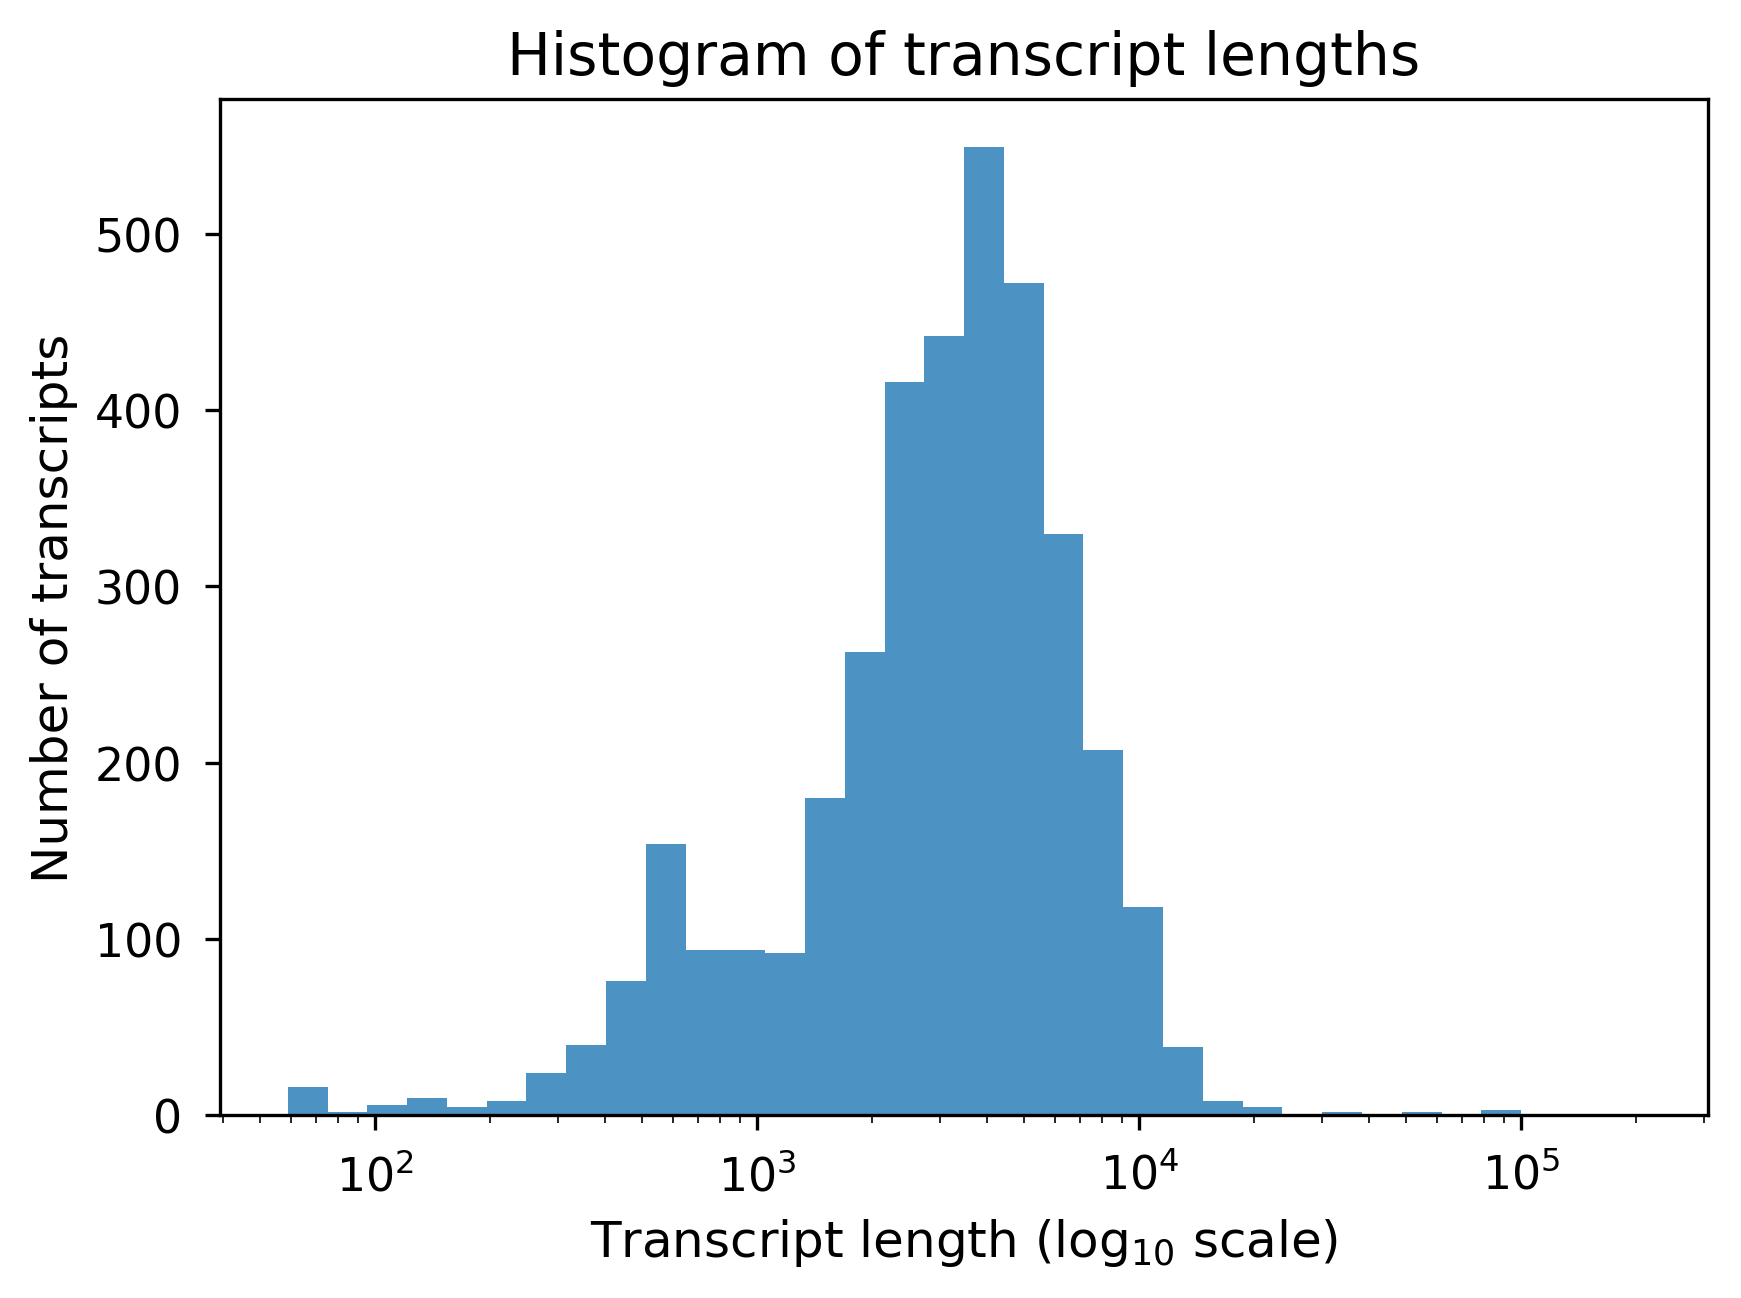

In [62]:
# Plot the transcript lengths
importlib.reload(plotting_utils)
fig, ax = plt.subplots(dpi=300)
seq_lens_logbins = np.logspace(np.log10(min(seq_lens)), np.log10(max(seq_lens)), 35)
ax.hist(seq_lens, bins=seq_lens_logbins, alpha=0.8, density=False)
ax.set(
    xlabel=r"Transcript length ($\log_{10}$ scale)",
    ylabel="Number of transcripts",
    title="Histogram of transcript lengths",
    xscale='log',
)
fig.savefig(os.path.join(PLOT_DIR, "trans_len_histogram.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

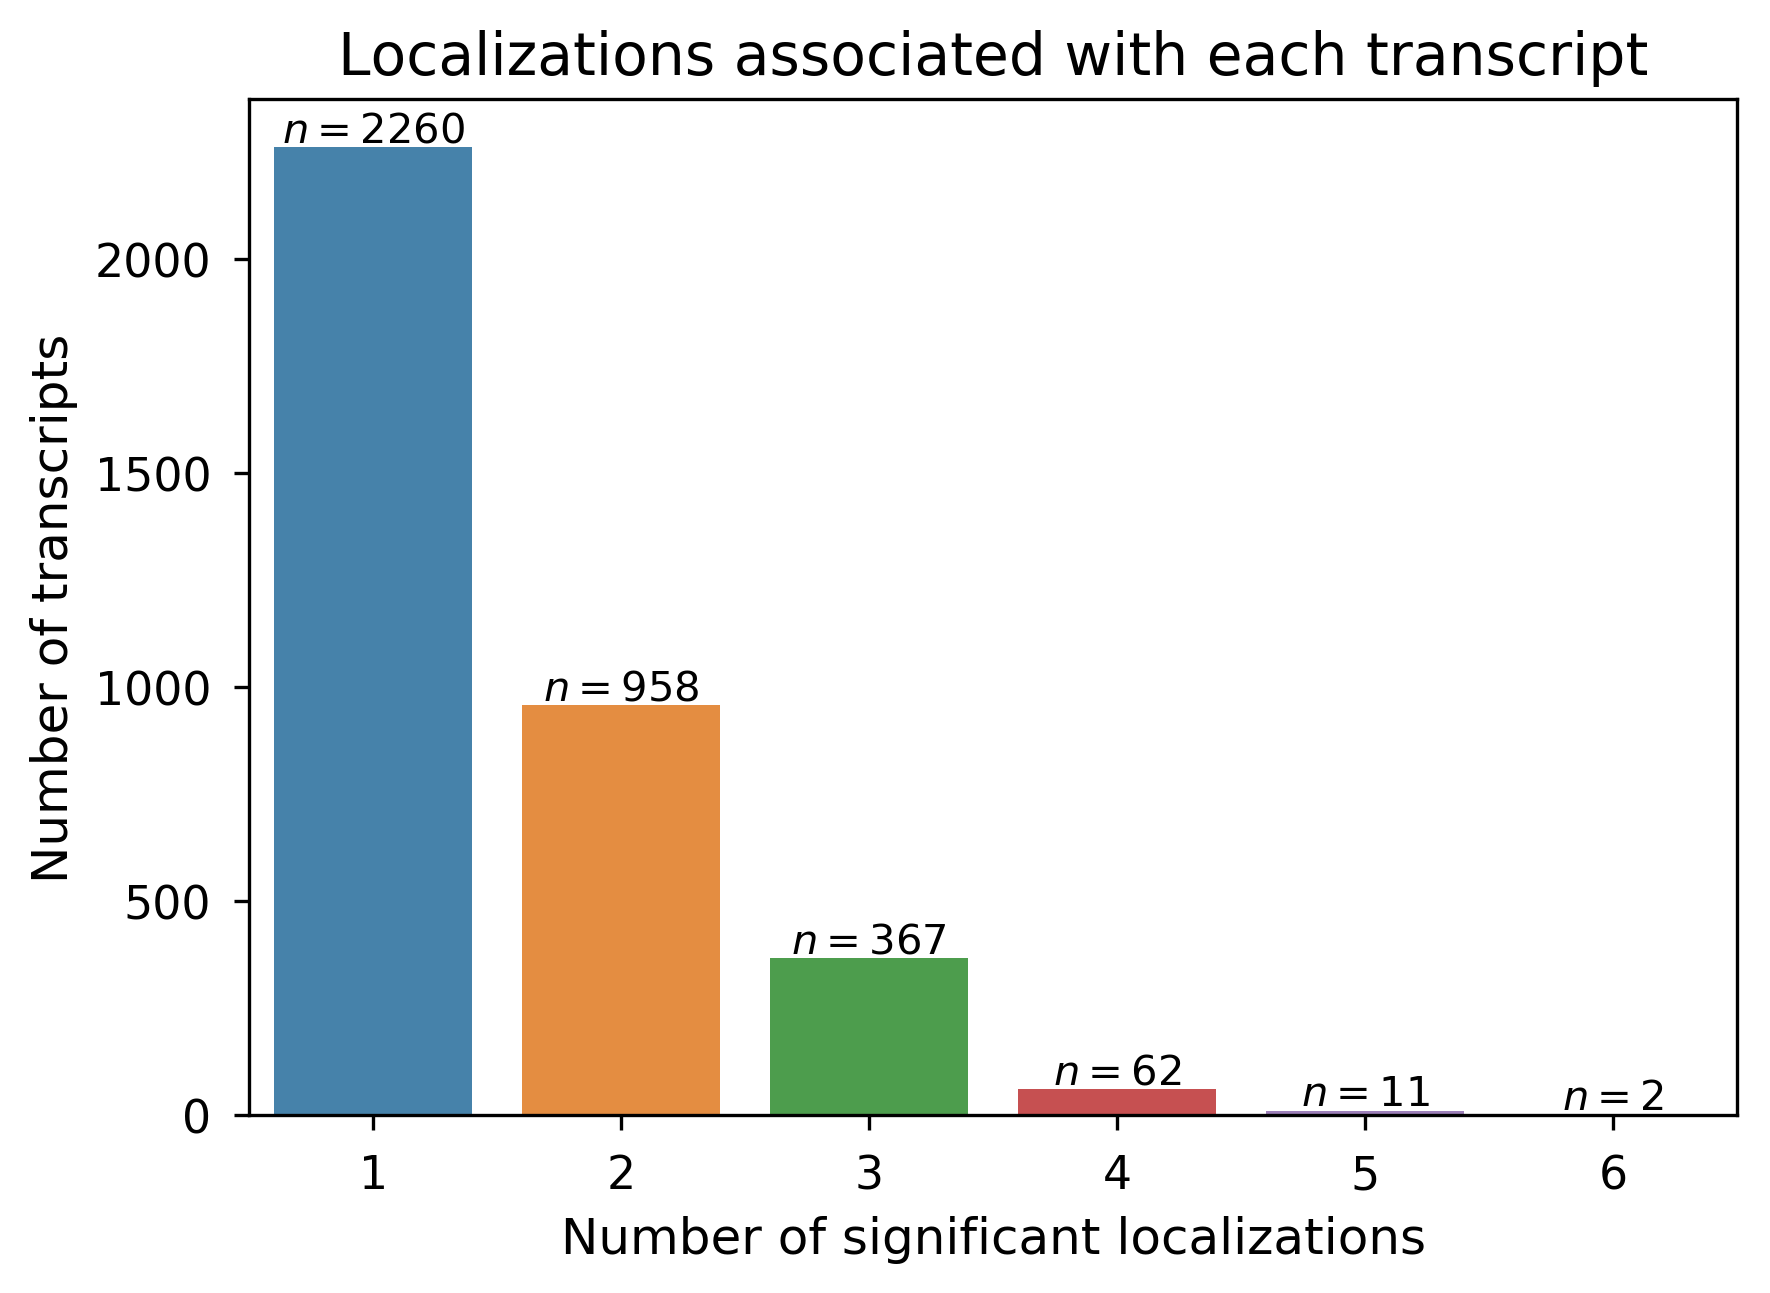

In [63]:
num_localizations = full_data[1].sum(axis=1)
localization_num, localization_num_counts = np.unique(num_localizations, return_counts=True)
fig, ax = plt.subplots(dpi=300)
sns.barplot(x=localization_num.astype(int), y=localization_num_counts, alpha=0.9)
ax.set(
    xlabel="Number of significant localizations",
    ylabel="Number of transcripts",
    title="Localizations associated with each transcript",
)
for p in ax.patches:
    ax.annotate(
        f"$n={int(p.get_height())}$",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 4),
        textcoords='offset points',
    )
fig.savefig(os.path.join(PLOT_DIR, "colocal_hist.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

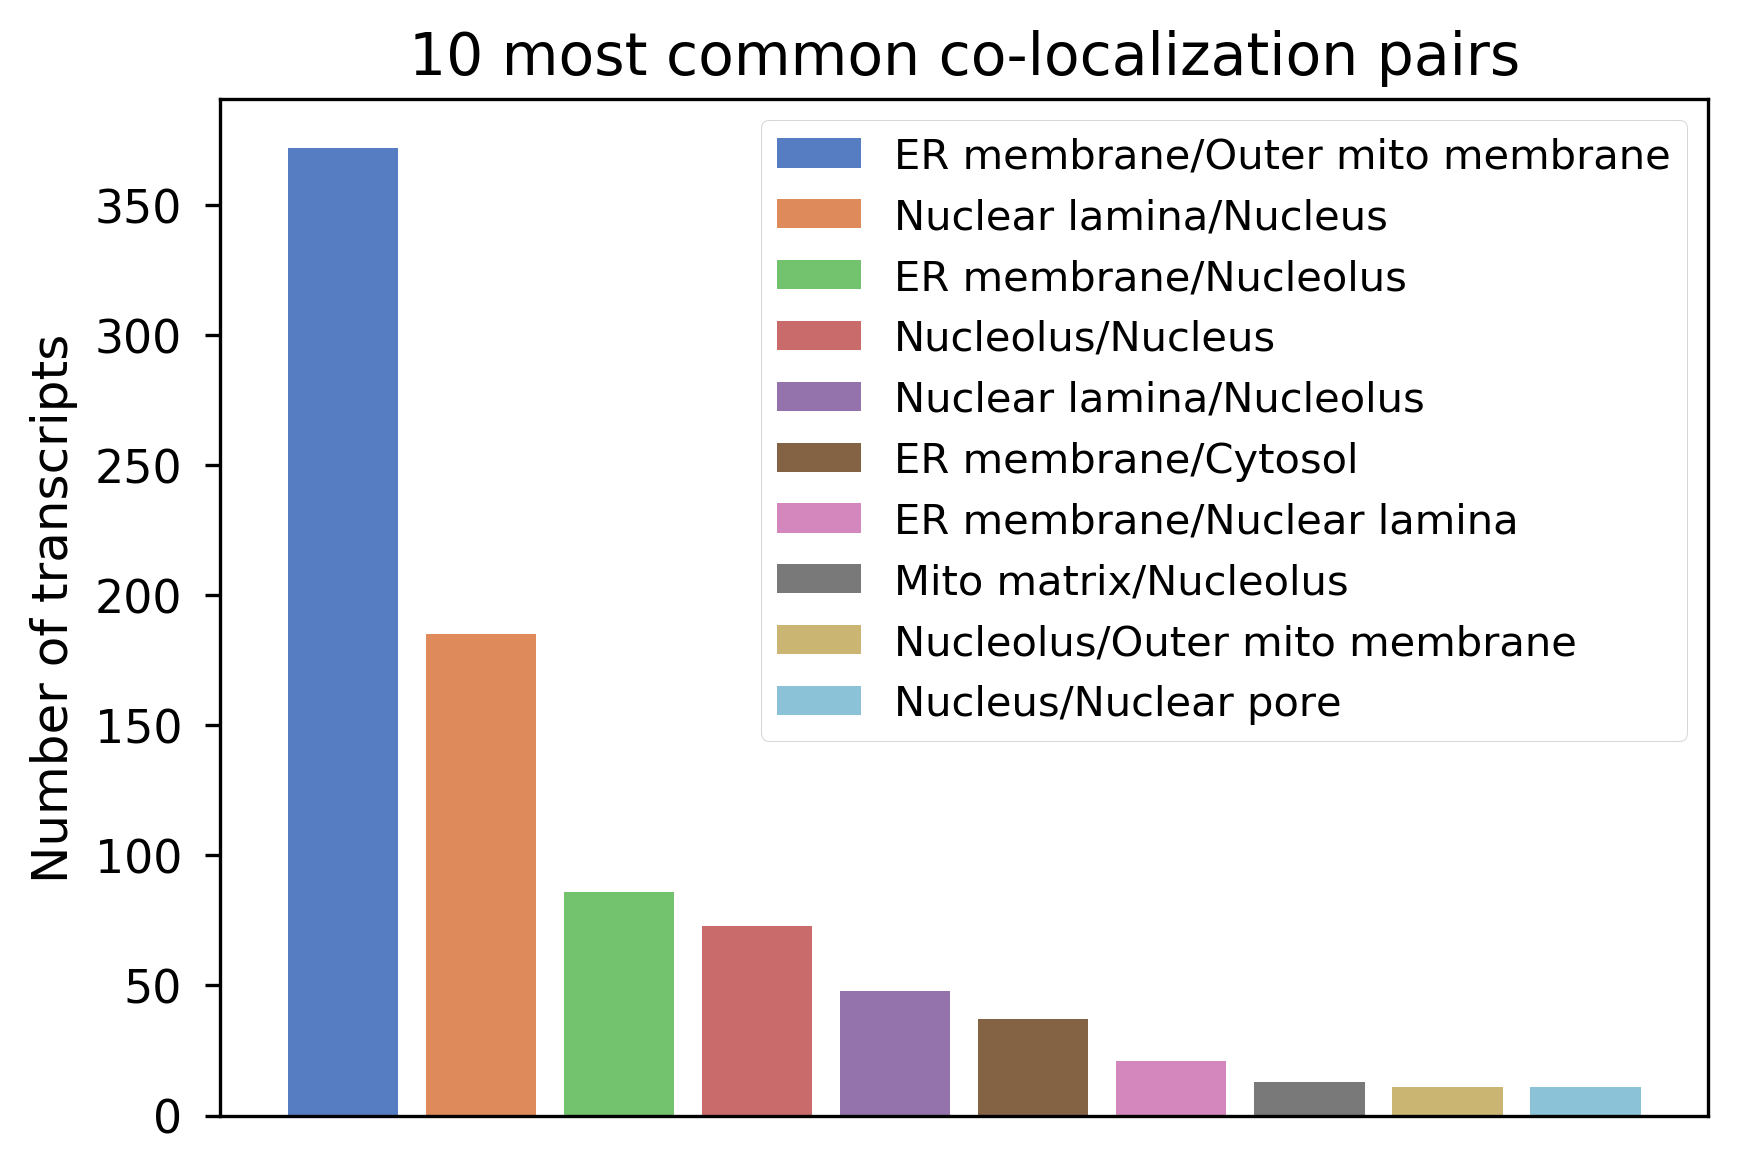

In [64]:
# Plot the most common co-localizations
colocalizations = collections.Counter()
for i in range(len(full_dataset)):
    labels = full_dataset.truth_matrix[i, :]
    if sum(labels) != 2:
        continue
    compartments = sorted([full_dataset.compartments[idx] for idx, truth in enumerate(labels) if truth])
    compartments_readable = "/".join([data_loader.LOCALIZATION_FULL_NAME_DICT[c] for c in compartments])
    colocalizations.update([compartments_readable])

common_colocalizations = colocalizations.most_common(10)  # List of tuples (name, count)
fig, ax = plt.subplots(dpi=300)
for i, (name, count) in enumerate(common_colocalizations):
    ax.bar(
        i,
        count,
        label=name,
        color=sns.color_palette(palette="muted", n_colors=10, desat=0.8)[i]
    )
ax.legend()
ax.set(
    xticklabels=[],  # Clear xlabels
    title="10 most common co-localization pairs",
    xticks=[],  # Clear x ticks
    ylabel="Number of transcripts"
)
fig.savefig(os.path.join(PLOT_DIR, "common_2_colocal.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

In [8]:
# Random forest classifier
rf_kwargs = {
    "n_estimators": 250,
    "n_jobs": 48,
    "class_weight": "balanced",
}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data,
    valid_data,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf.auprc))

Validation AUROC: 0.7208197130801877
Validation AUPRC: 0.38267919743336565


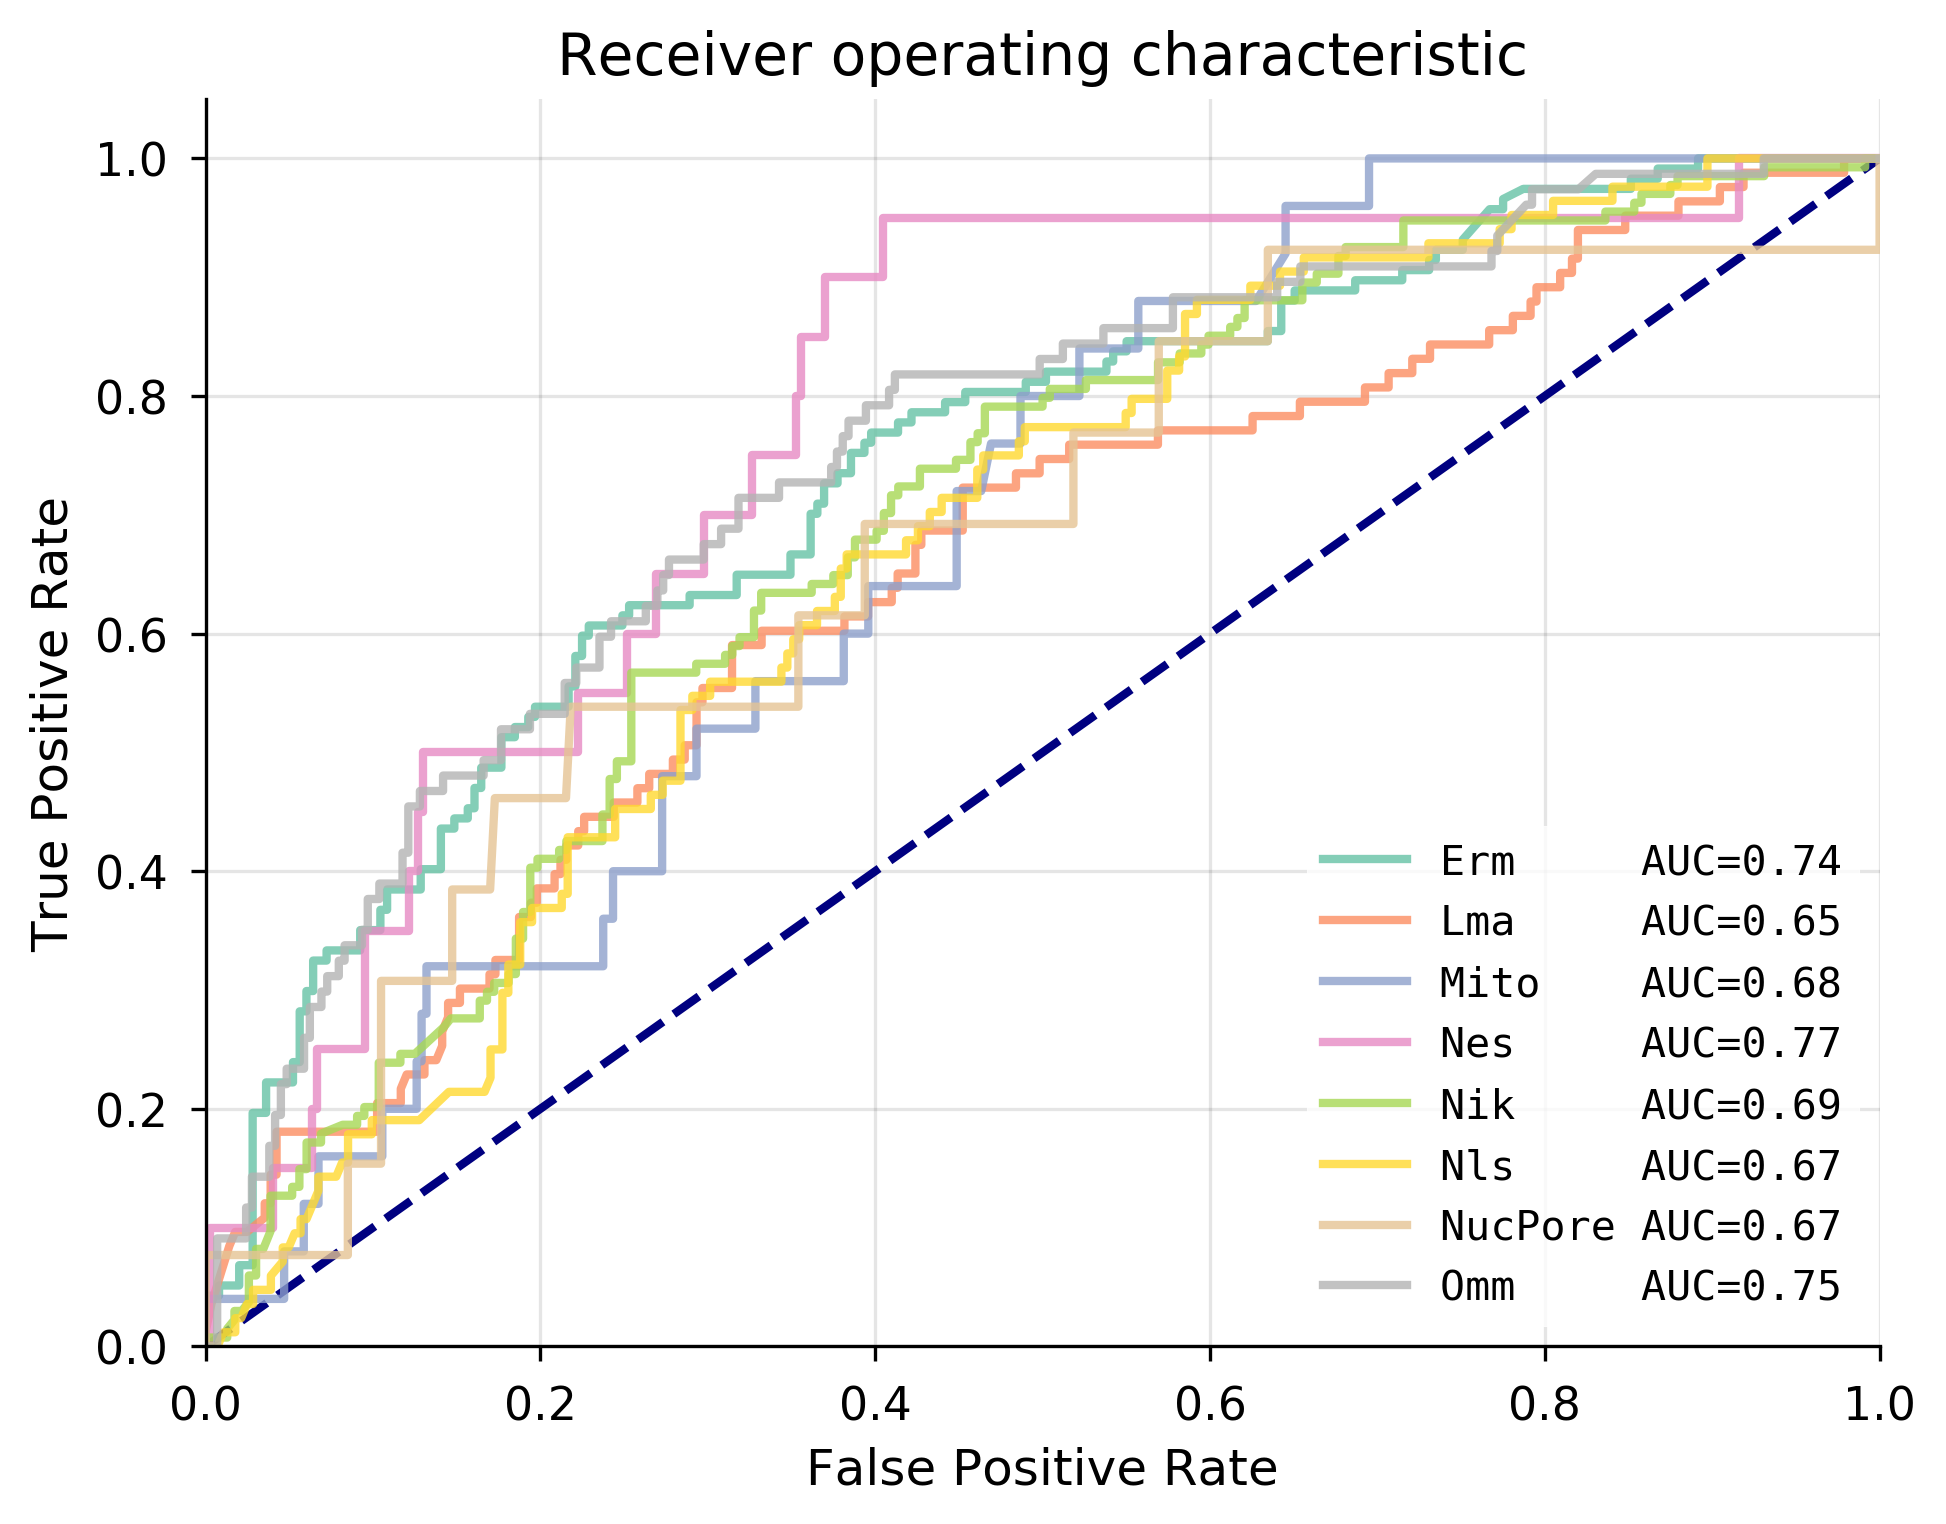

In [61]:
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_per_class_perf)}
)

## Hyperparameter tuning

In [10]:
rf_n_estimators = [100, 150, 200, 250, 300]
rf_criterion = ["gini", "entropy"]
rf_max_depth = [None, 25, 50, 100]
rf_min_samples_leaf = [0.001, 0.01, 0.1]
rf_max_features = ['sqrt']  # ["sqrt", "log2"]
rf_class_weight = [None]  # ['balanced', None]

param_combos = list(itertools.product(
    rf_n_estimators,
    rf_criterion,
    rf_max_depth,
    rf_min_samples_leaf,
    rf_max_features,
    rf_class_weight,
))
param_combos_overall_perf = []
param_combos_class_perf = []
param_combos_models = []
importlib.reload(model_utils)
for n_est, crit, depth, min_samp, max_feat, weight in tqdm.tqdm_notebook(param_combos):
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 64,
        "random_state": 39282,
    }
    rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
        RandomForestClassifier(**rf_param_dict),
        train_data,
        valid_data,
        verbose=False
    )
    param_combos_models.append(rf_model)
    param_combos_overall_perf.append(rf_overall_perf)
    param_combos_class_perf.append(rf_per_class_perf)

In [11]:
auroc_values = [p.auroc for p in param_combos_overall_perf]
print(max(auroc_values), param_combos[np.argmax(auroc_values)])
auprc_values = [p.auprc for p in param_combos_overall_perf]
print(max(auprc_values), param_combos[np.argmax(auprc_values)])

0.7467255385060354 (300, 'entropy', None, 0.001, 'sqrt', None)
0.4273466734476469 (300, 'gini', 25, 0.001, 'sqrt', None)


The best parameters according to AUROC:
```
(300, 'entropy', 100, 0.001, 'sqrt', None)
```

{'n_estimators': 300, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'class_weight': None, 'n_jobs': 24, 'random_state': 39282}
Validation AUROC: 0.7467255385060354
Validation AUROC var: 0.001051827871399765
Validation AUPRC: 0.4103248524326642
Validation AUPRC var: 0.032656338645072655


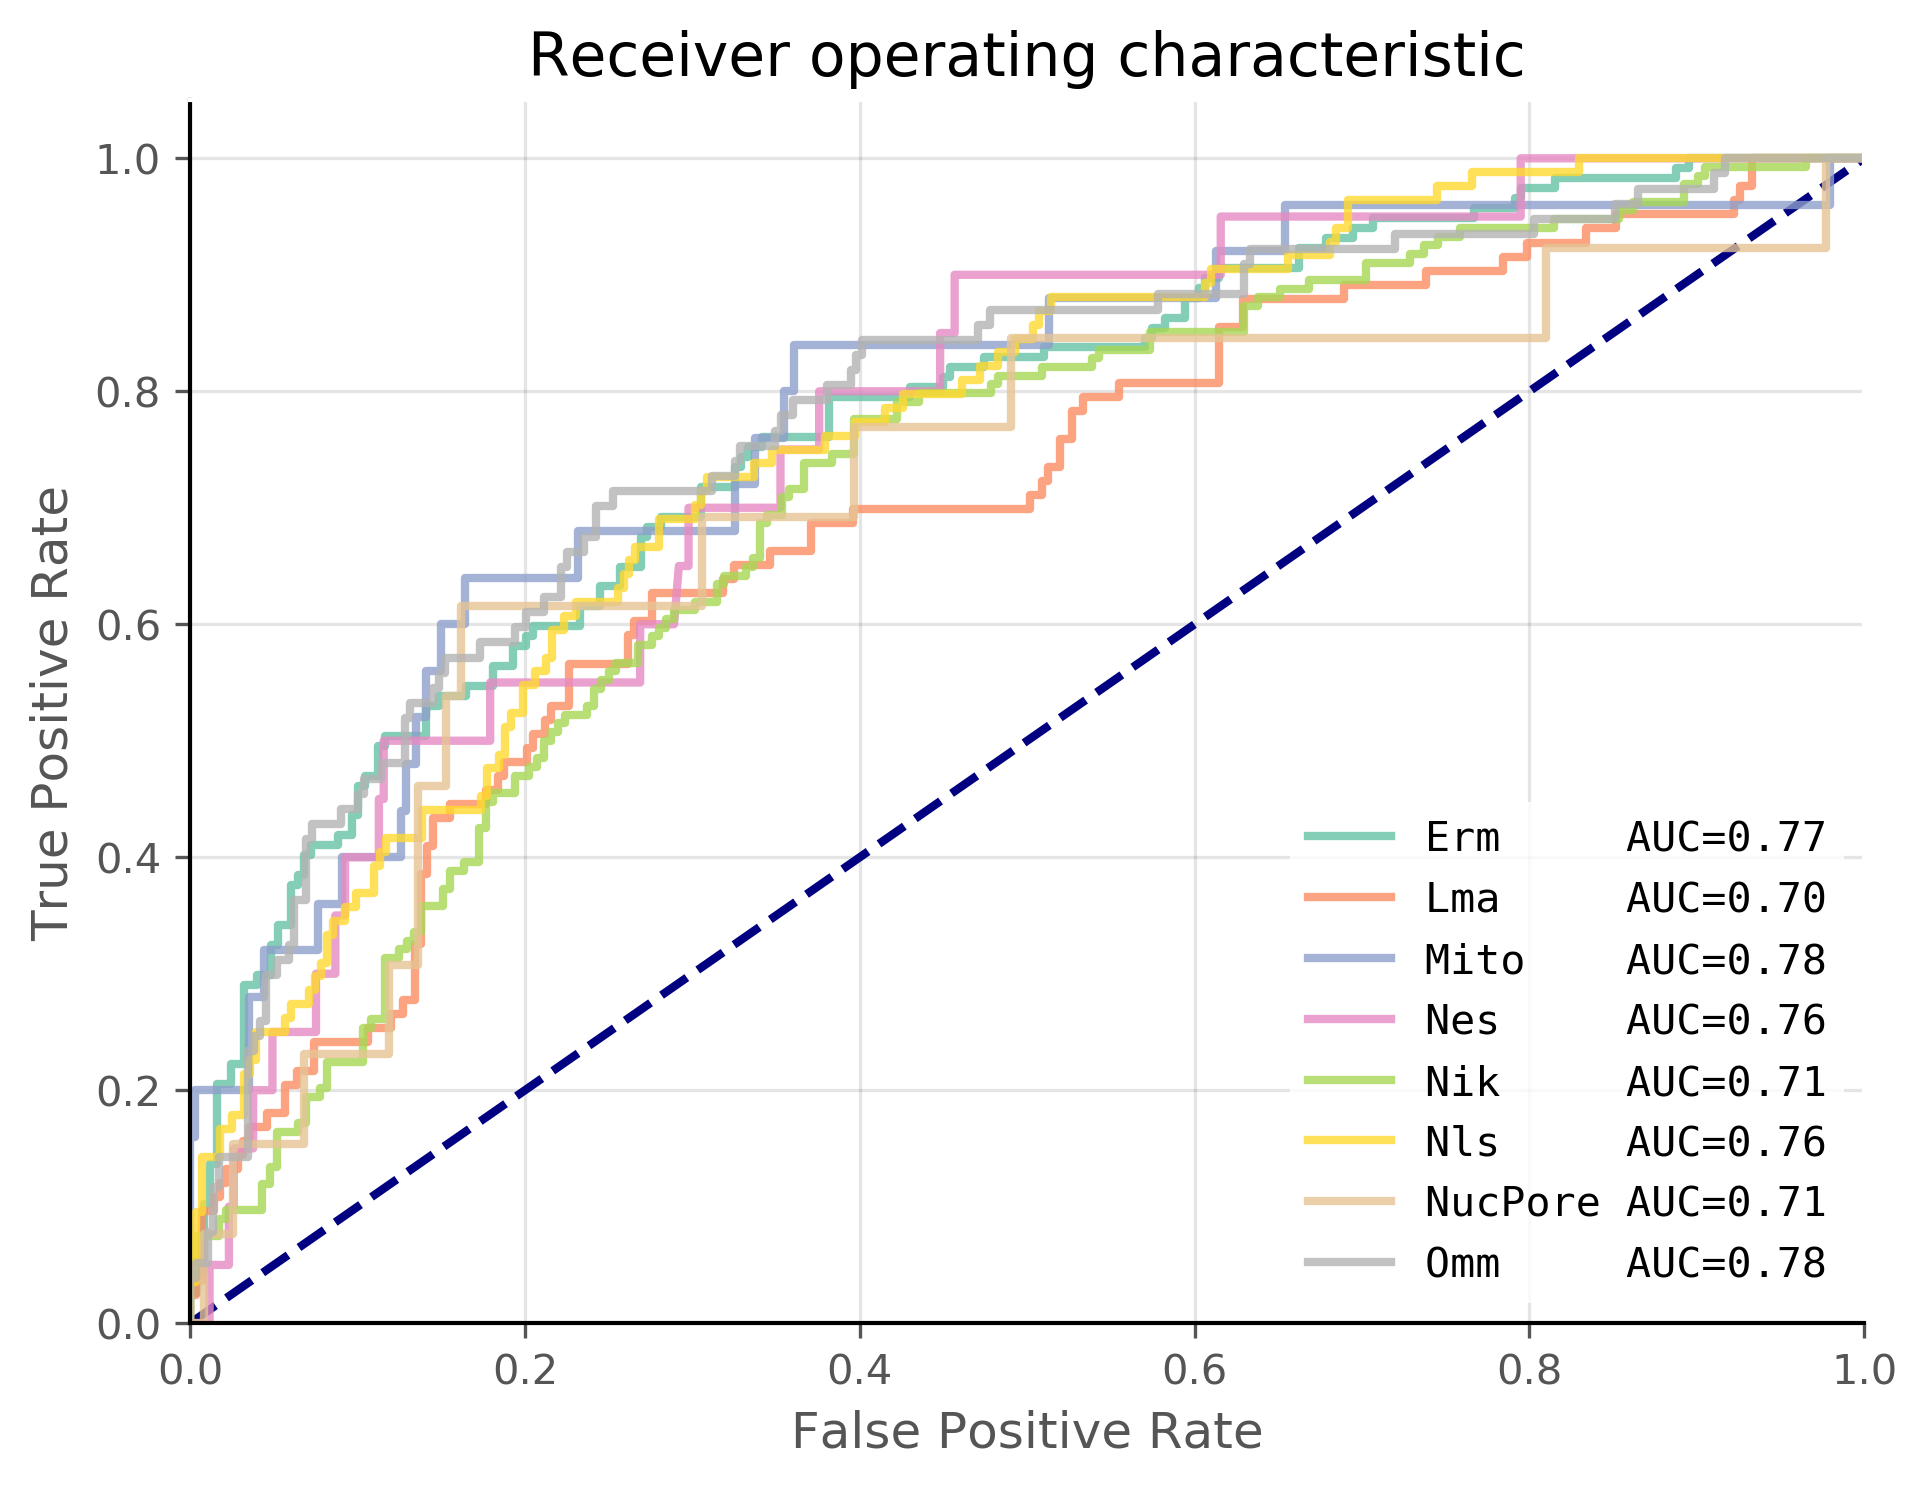

In [12]:
rf_optimal_index = np.argmax(auroc_values)
rf_optimal_model = param_combos_models[rf_optimal_index]
rf_optimal_class_perf = param_combos_class_perf[rf_optimal_index]
rf_optimal_perf = param_combos_overall_perf[rf_optimal_index]

rf_optimal_params = param_combos[rf_optimal_index]
rf_optimal_param_dict = {
    "n_estimators": rf_optimal_params[0],
    "criterion": rf_optimal_params[1],
    "max_depth": rf_optimal_params[2],
    "min_samples_leaf": rf_optimal_params[3],
    "max_features": rf_optimal_params[4],
    "class_weight": rf_optimal_params[5],
    "n_jobs": 24,
    "random_state": 39282,
}
print(rf_optimal_param_dict)

print("Validation AUROC: {}".format(rf_optimal_perf.auroc))
print("Validation AUROC var: {}".format(np.var([p.auroc for p in rf_optimal_class_perf])))
print("Validation AUPRC: {}".format(rf_optimal_perf.auprc))
print("Validation AUPRC var: {}".format(np.var([p.auprc for p in rf_optimal_class_perf])))
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_optimal_class_perf)}
)

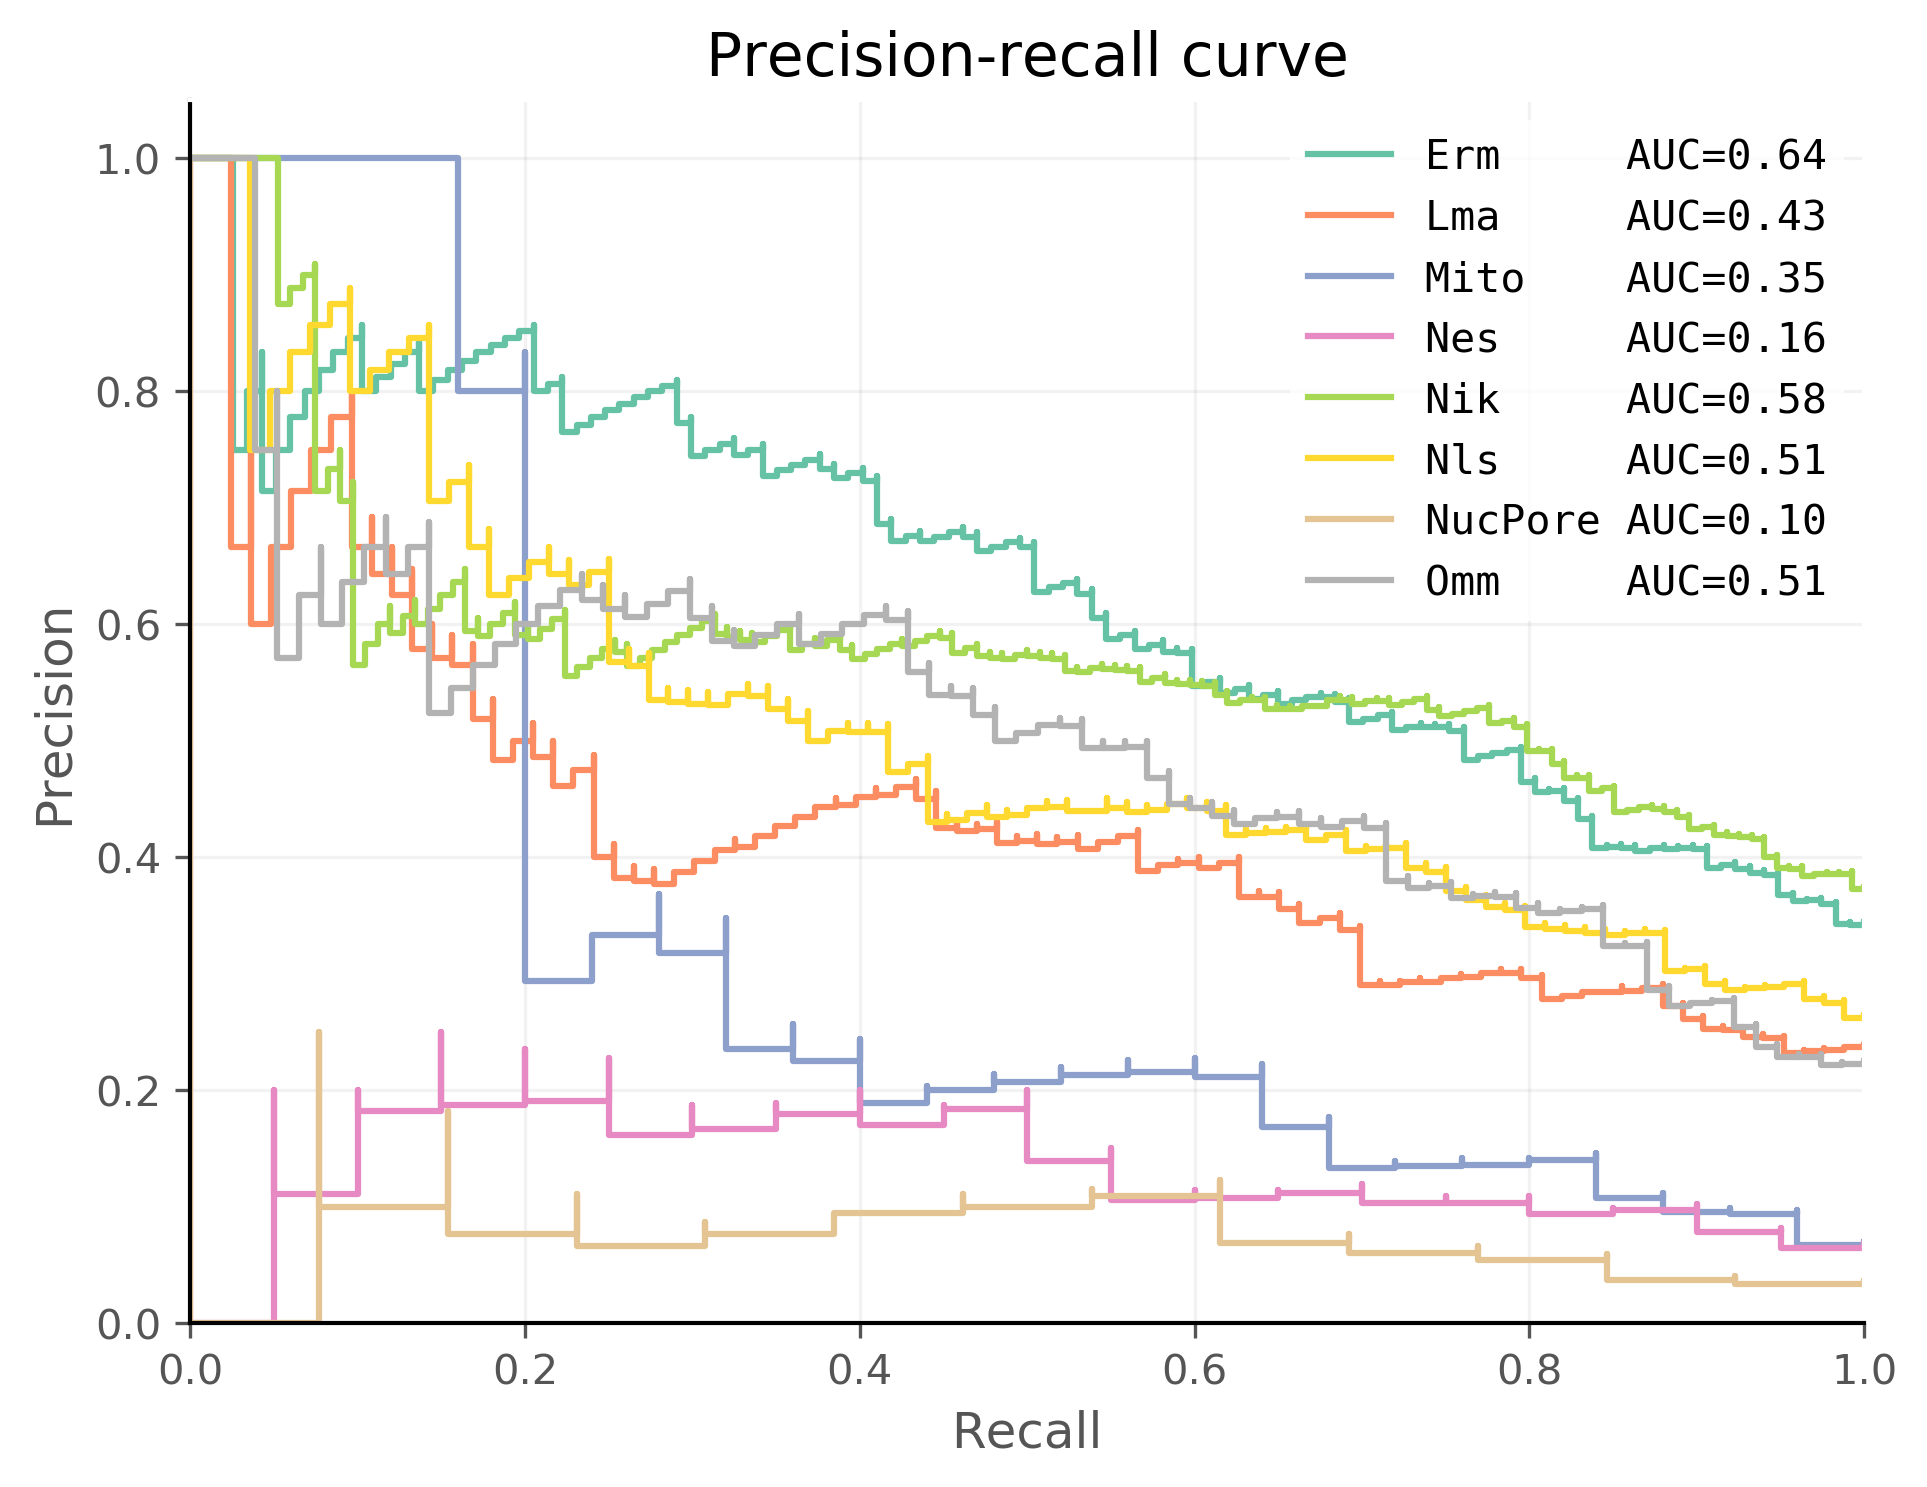

In [13]:
importlib.reload(plotting_utils)
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_optimal_class_perf)}
)

Test set achieves following performance:
* AUROC = 0.7679
* AUPRC = 0.4944

TEST SET
0.7678688021252544
0.49441421899593996


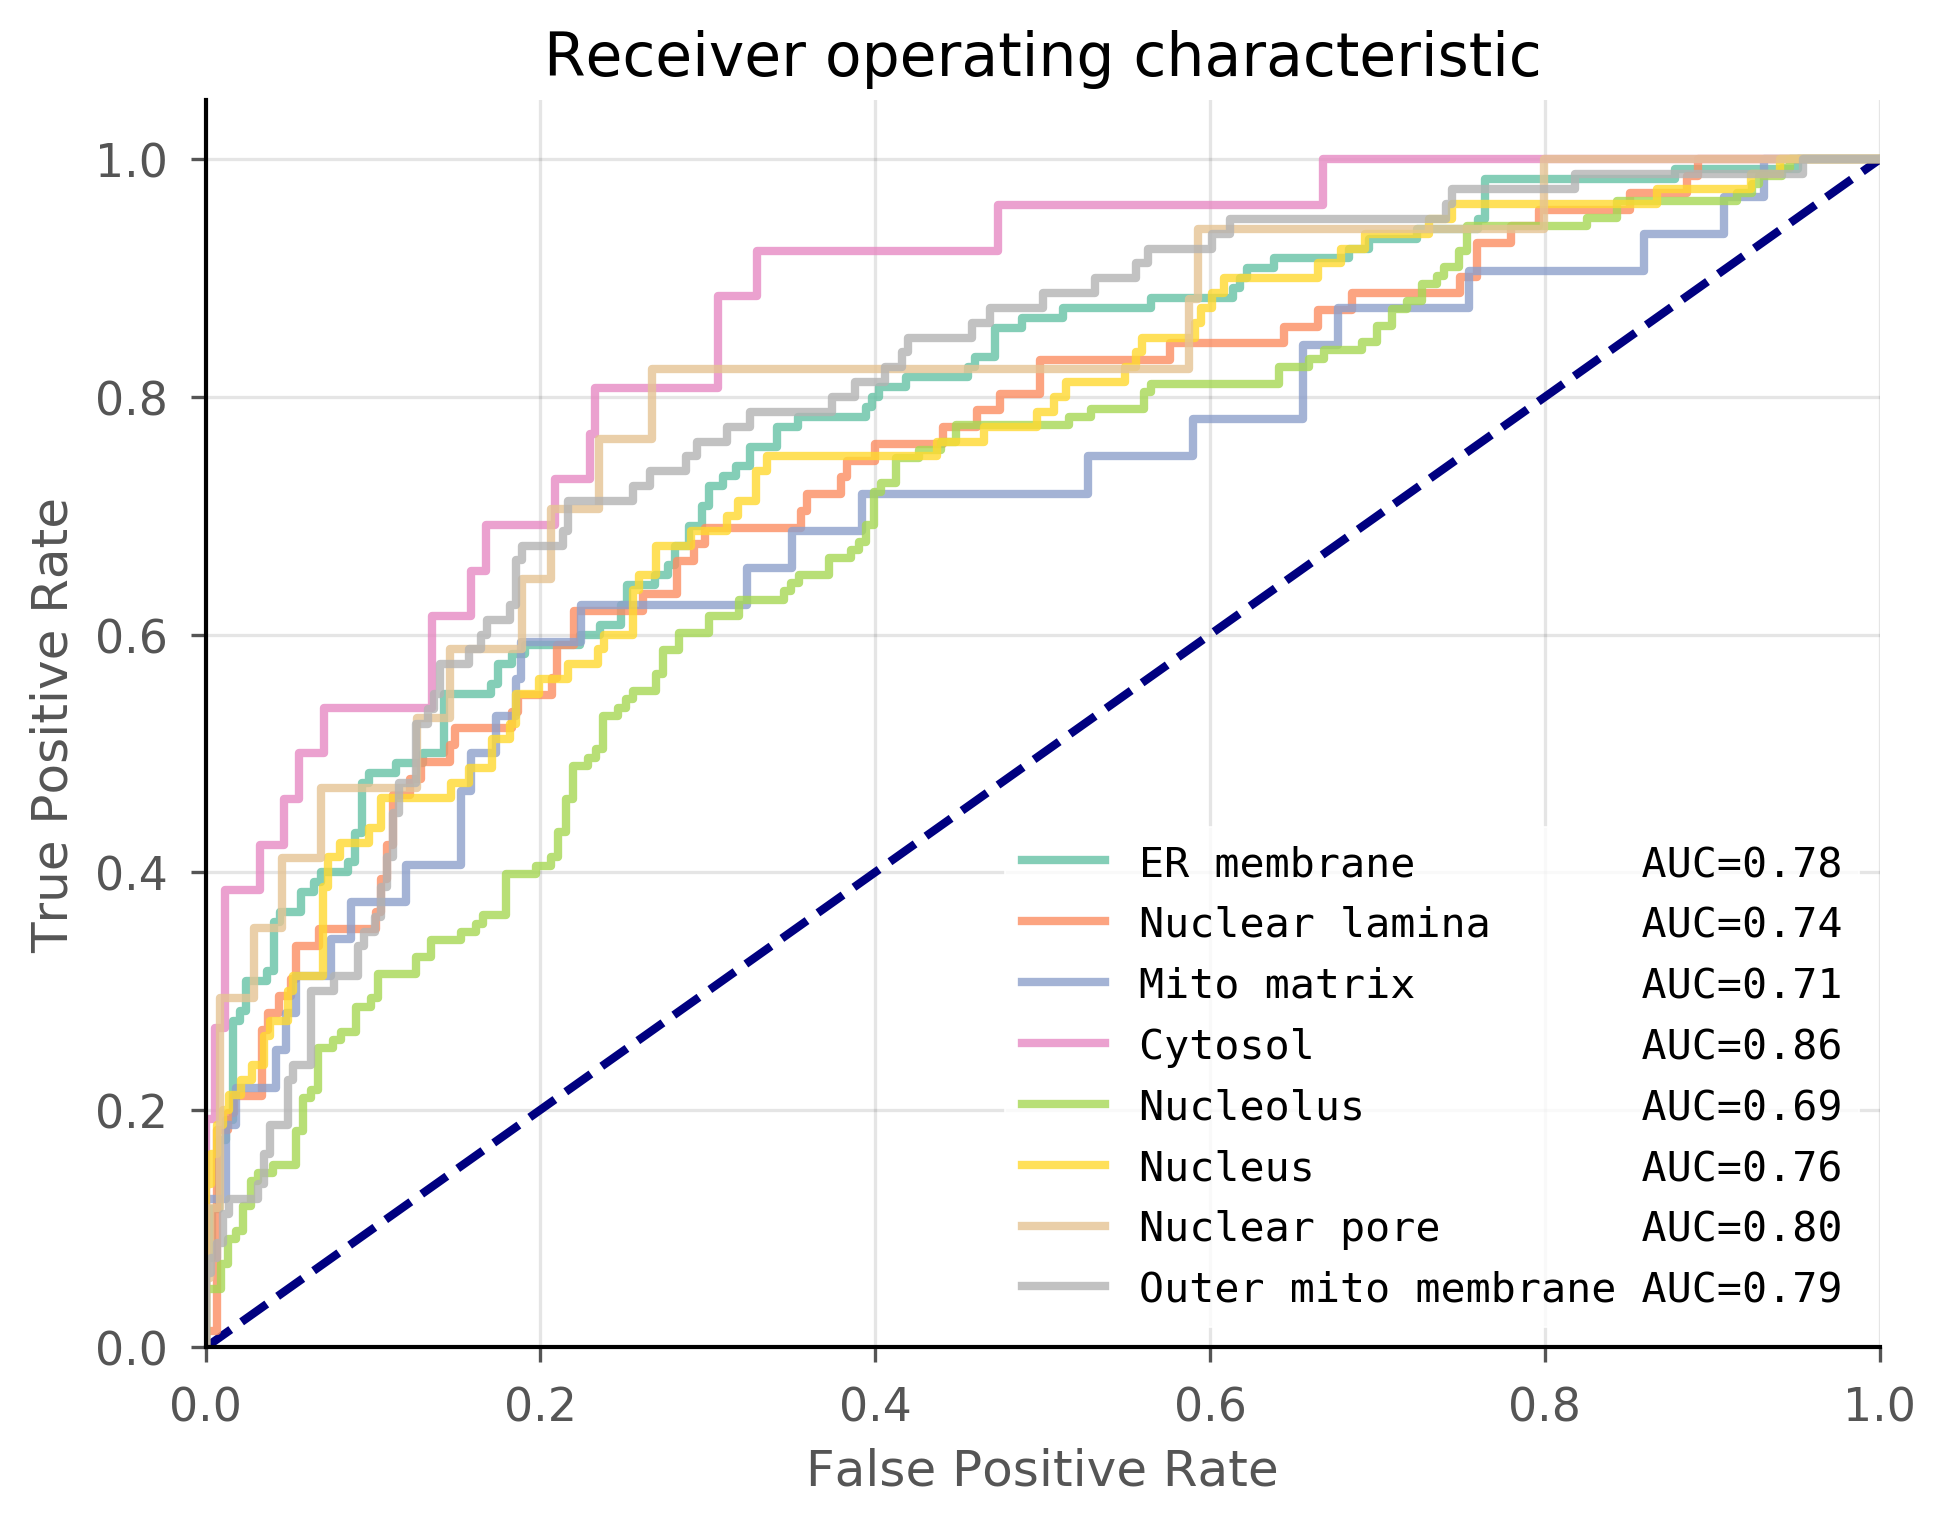

In [65]:
# Same as above, but for test set
importlib.reload(model_utils)
rf_test_prob_matrix = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_data[0]))
rf_test_per_class_perf = model_utils.generate_multiclass_perf(test_data[1], rf_test_prob_matrix, 8)
rf_test_overall_perf = model_utils.generate_model_perf(test_data[1], rf_test_prob_matrix, multiclass=True)

print("TEST SET")
print(rf_test_overall_perf.auroc)
print(rf_test_overall_perf.auprc)
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(test_dataset.compartments, rf_test_per_class_perf)},
    bg_color='white',
    fname=os.path.join(PLOT_DIR, "rnafinder_auroc.pdf"),
)

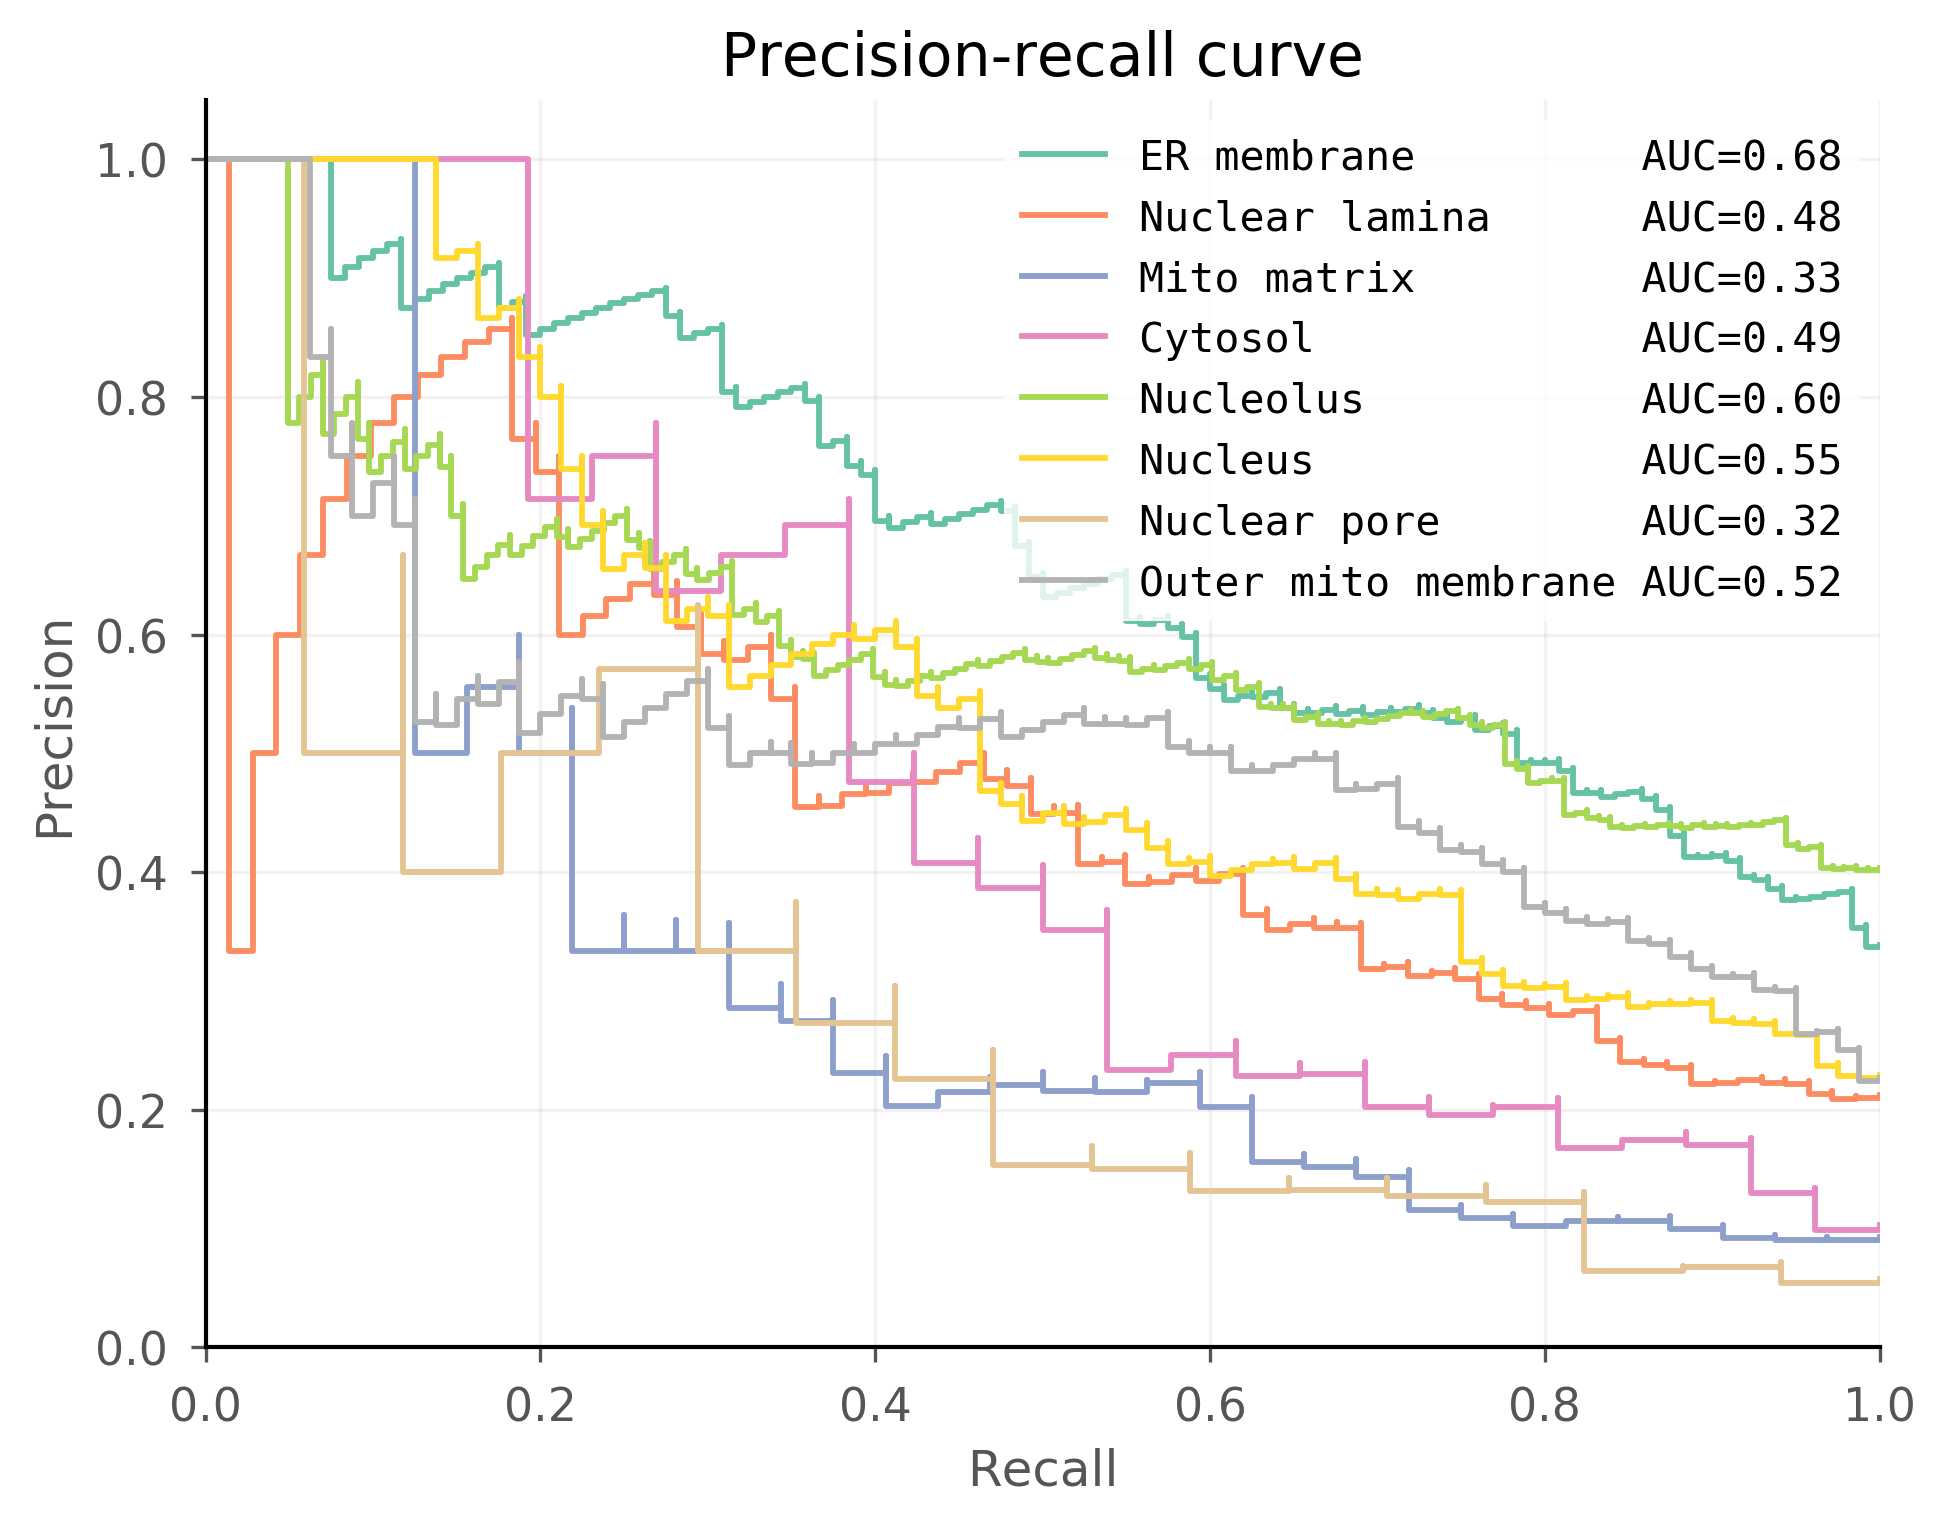

In [66]:
importlib.reload(plotting_utils)
plotting_utils.plot_auprc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(test_dataset.compartments, rf_test_per_class_perf)},
    grid=True,
    bg_color='white',
    fname=os.path.join(PLOT_DIR, "rnafinder_auprc.pdf"),
)

In [16]:
# Accuracy based on validation cutoffs
valid_preds = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(valid_data[0]))
valid_youden_cutoffs = np.array([model_utils.youden_threshold(preds=valid_preds[:, i], truth=valid_data[1][:, i]) for i in range(8)])

test_probs = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_data[0]))
test_preds = np.array(test_probs > valid_youden_cutoffs).astype(int)
accuracies = np.array([metrics.accuracy_score(test_data[1][:, i], test_preds[:, i]) for i in range(8)])
accuracies

array([0.69125683, 0.74863388, 0.63934426, 0.58469945, 0.64754098,
       0.68032787, 0.82240437, 0.7704918 ])

In [17]:
np.mean(accuracies)

0.6980874316939891

In [18]:
utils.save_sklearn_model(rf_optimal_model, os.path.join(os.path.dirname(SRC_DIR), 'models', f'rf_8way_fold{K_FOLD}'))

'/storage/wukevin/projects/rnagps/models/rf_8way_fold5.0.21.3.skmodel'

In [19]:
importlib.reload(utils)
rf_optimal_model = utils.load_sklearn_model(
    os.path.join(os.path.dirname(SRC_DIR), 'models', f'rf_8way_fold{K_FOLD}.0.21.3.skmodel')
)

## Performance of singly trained models

In [20]:
from sklearn.multiclass import OneVsRestClassifier

importlib.reload(model_utils)
ovr_rf_model, ovr_rf_per_class_perf, ovr_rf_overall_perf = model_utils.multi_train(
    OneVsRestClassifier(RandomForestClassifier(**rf_optimal_param_dict), n_jobs=8),
    train_data,
    valid_data,
    verbose=False
)

Validation AUROC: 0.7410580442310843
Validation AUROC var: 0.0008187044134016837
Validation AUPRC: 0.4236732733394854
Validation AUPRC var: 0.030845926253757323


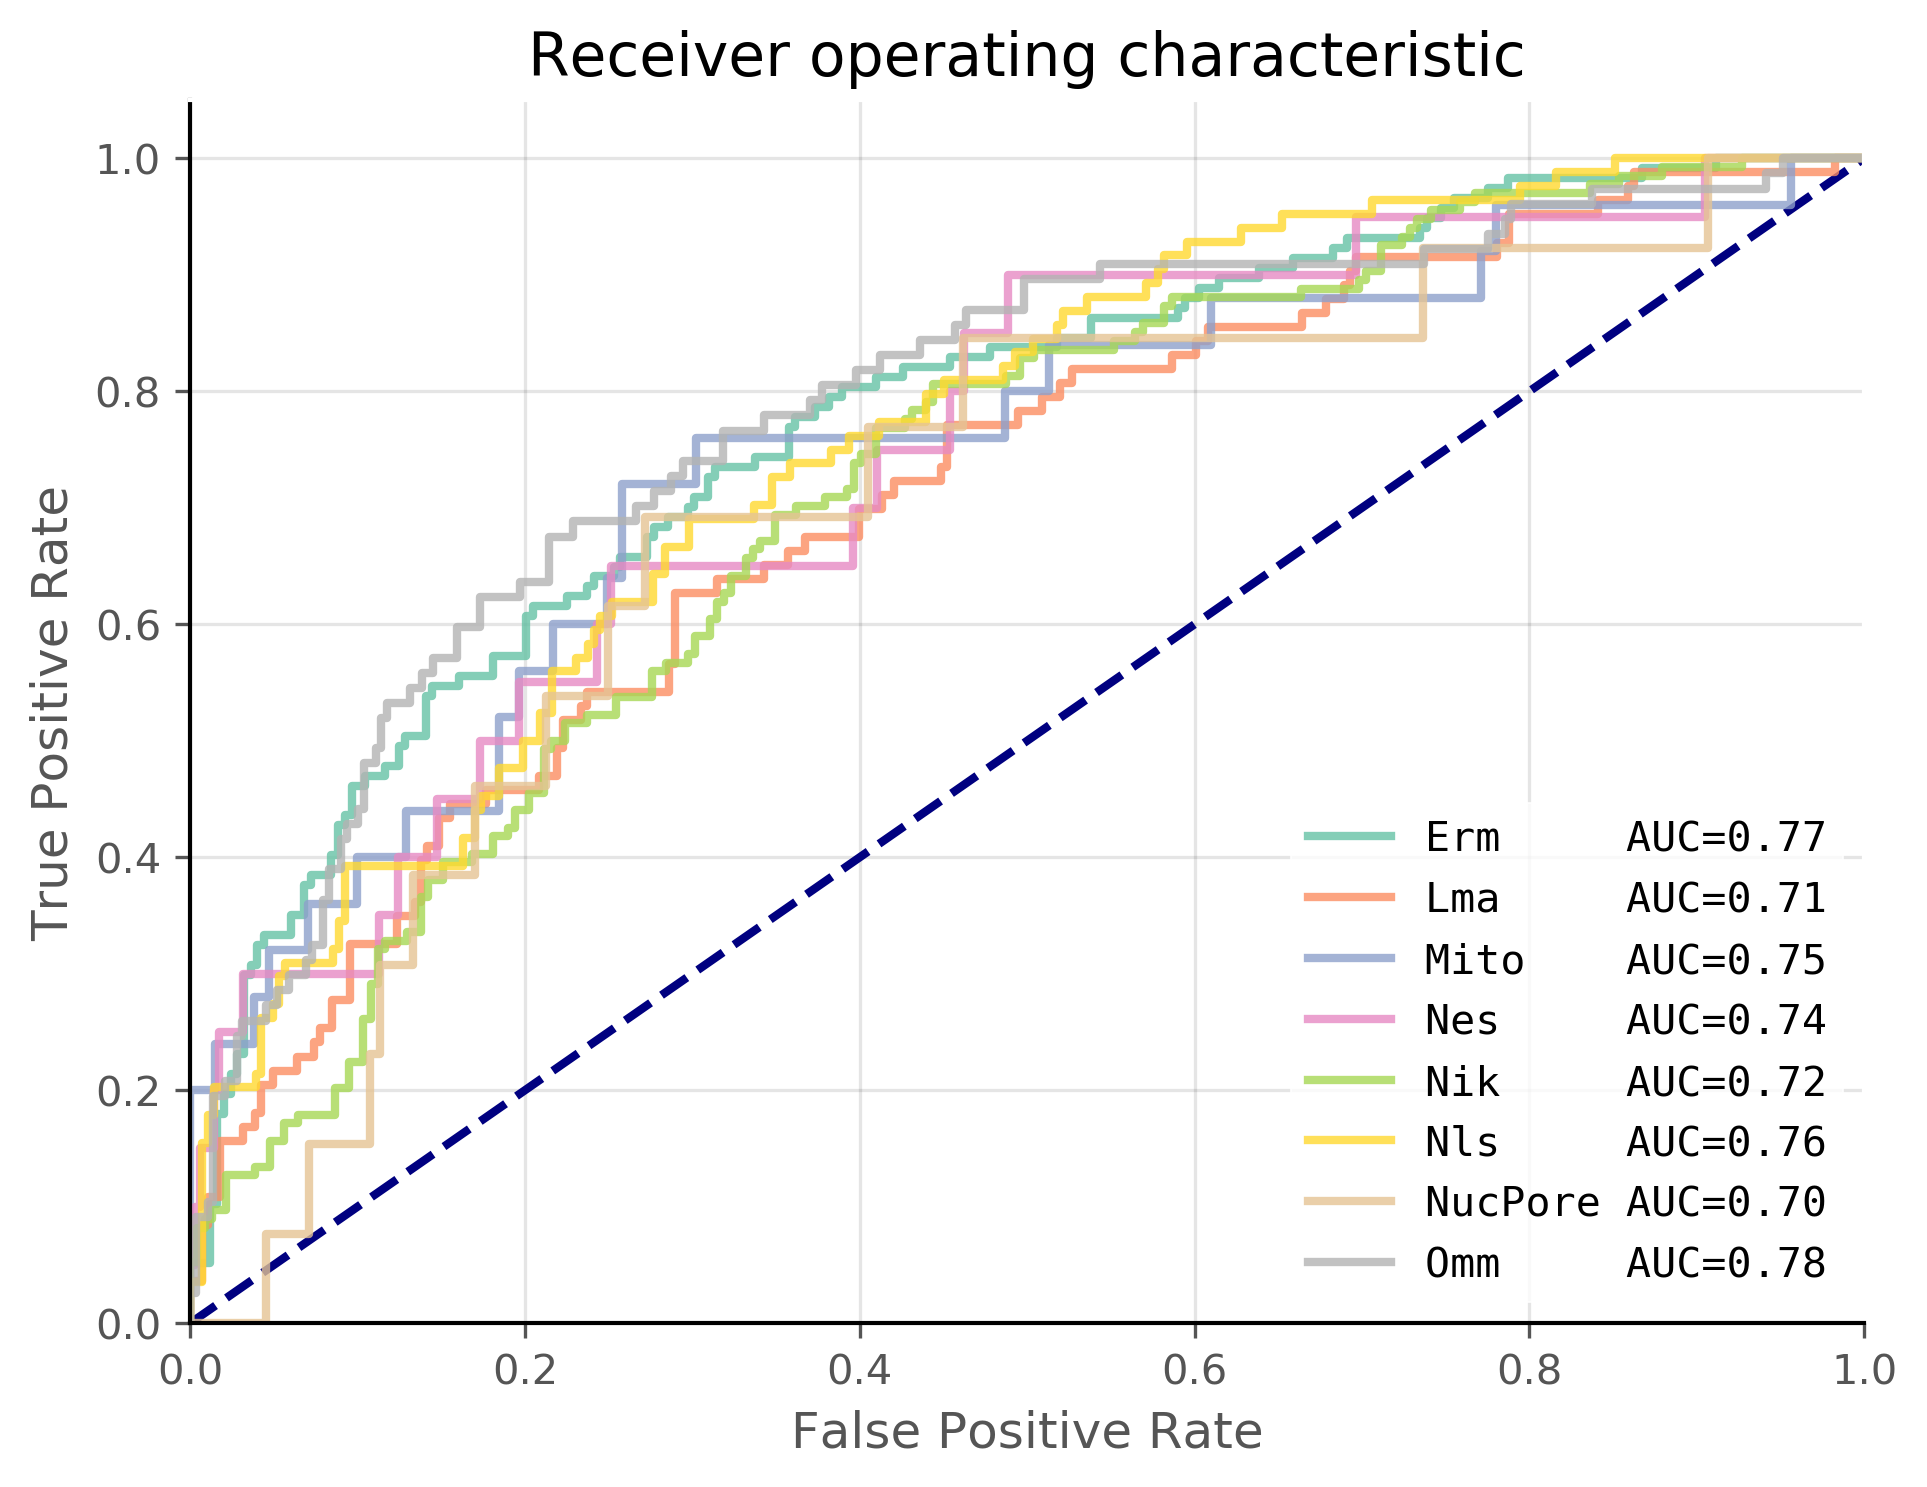

In [21]:
print("Validation AUROC: {}".format(ovr_rf_overall_perf.auroc))
print("Validation AUROC var: {}".format(np.var([p.auroc for p in ovr_rf_per_class_perf])))
print("Validation AUPRC: {}".format(ovr_rf_overall_perf.auprc))
print("Validation AUPRC var: {}".format(np.var([p.auprc for p in ovr_rf_per_class_perf])))

plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, ovr_rf_per_class_perf)}
)

In [22]:
import xgboost as xgb

xgb_max_depths = [4, 6, 8]  # [3, 4, 6]
xgb_learning_rate = [0.1, 0.02]
xgb_n_estimators = [100, 200]
xgb_boosters = ['gbtree', 'gblinear', 'dart']  # Only gbtree is interpretable by shap
xgb_gamma = [0.01]  # [0, 0.01]
xgb_reg_alpha = [0, 1]

xgb_param_combos = []
ovr_xgb_models, ovr_xgb_per_class_perfs, ovr_xgb_overall_perfs = [], [], []
for param_combo in tqdm.tqdm_notebook(list(itertools.product(xgb_max_depths, xgb_learning_rate, xgb_n_estimators, xgb_boosters, xgb_gamma, xgb_reg_alpha))):
    param_dict = {
        "max_depth": param_combo[0],
        "learning_rate": param_combo[1],
        "n_estimators": param_combo[2],
        "booster": param_combo[3],
        "gamma": param_combo[4],
        "reg_alpha": param_combo[5],
        "n_jobs": 8,
        "random_state": 2911,
        "reg_lambda": 0,
    }
    xgb_param_combos.append(param_dict)
    ovr_xgb_model, ovr_xgb_per_class_perf, ovr_xgb_overall_perf = model_utils.multi_train(
        OneVsRestClassifier(xgb.XGBClassifier(**param_dict), n_jobs=8),
        train_data,
        valid_data,
        verbose=False
    )
    ovr_xgb_models.append(ovr_xgb_model)
    ovr_xgb_per_class_perfs.append(ovr_xgb_per_class_perf)
    ovr_xgb_overall_perfs.append(ovr_xgb_overall_perf)


In [23]:
xgb_param_combos_auroc = [p.auroc for p in ovr_xgb_overall_perfs]
xgb_param_combos_auprc = [p.auprc for p in ovr_xgb_overall_perfs]
ovr_xgb_best_index = np.argmax(xgb_param_combos_auroc)
ovr_xgb_optimal_params = xgb_param_combos[ovr_xgb_best_index]
xgb_param_combos_auroc[ovr_xgb_best_index], xgb_param_combos_auprc[ovr_xgb_best_index]

(0.7397268258783547, 0.4235136724787214)

In [24]:
ovr_xgb_optimal_params

{'max_depth': 8,
 'learning_rate': 0.1,
 'n_estimators': 200,
 'booster': 'gbtree',
 'gamma': 0.01,
 'reg_alpha': 1,
 'n_jobs': 8,
 'random_state': 2911,
 'reg_lambda': 0}

In [25]:
# ovr_xgb_model, ovr_xgb_per_class_perf, ovr_xgb_overall_perf = model_utils.multi_train(
#     OneVsRestClassifier(xgb.XGBClassifier(**ovr_xgb_optimal_params), n_jobs=8),
#     train_data,
#     valid_data,
#     verbose=False
# )
ovr_xgb_model = ovr_xgb_models[ovr_xgb_best_index]
ovr_xgb_per_class_perf = ovr_xgb_per_class_perfs[ovr_xgb_best_index]
ovr_xgb_overall_perf = ovr_xgb_overall_perfs[ovr_xgb_best_index]

Validation AUROC: 0.7397268258783547
Validation AUROC var: 0.0017913244372965648
Validation AUPRC: 0.4235136724787214
Validation AUPRC var: 0.030864695523675607


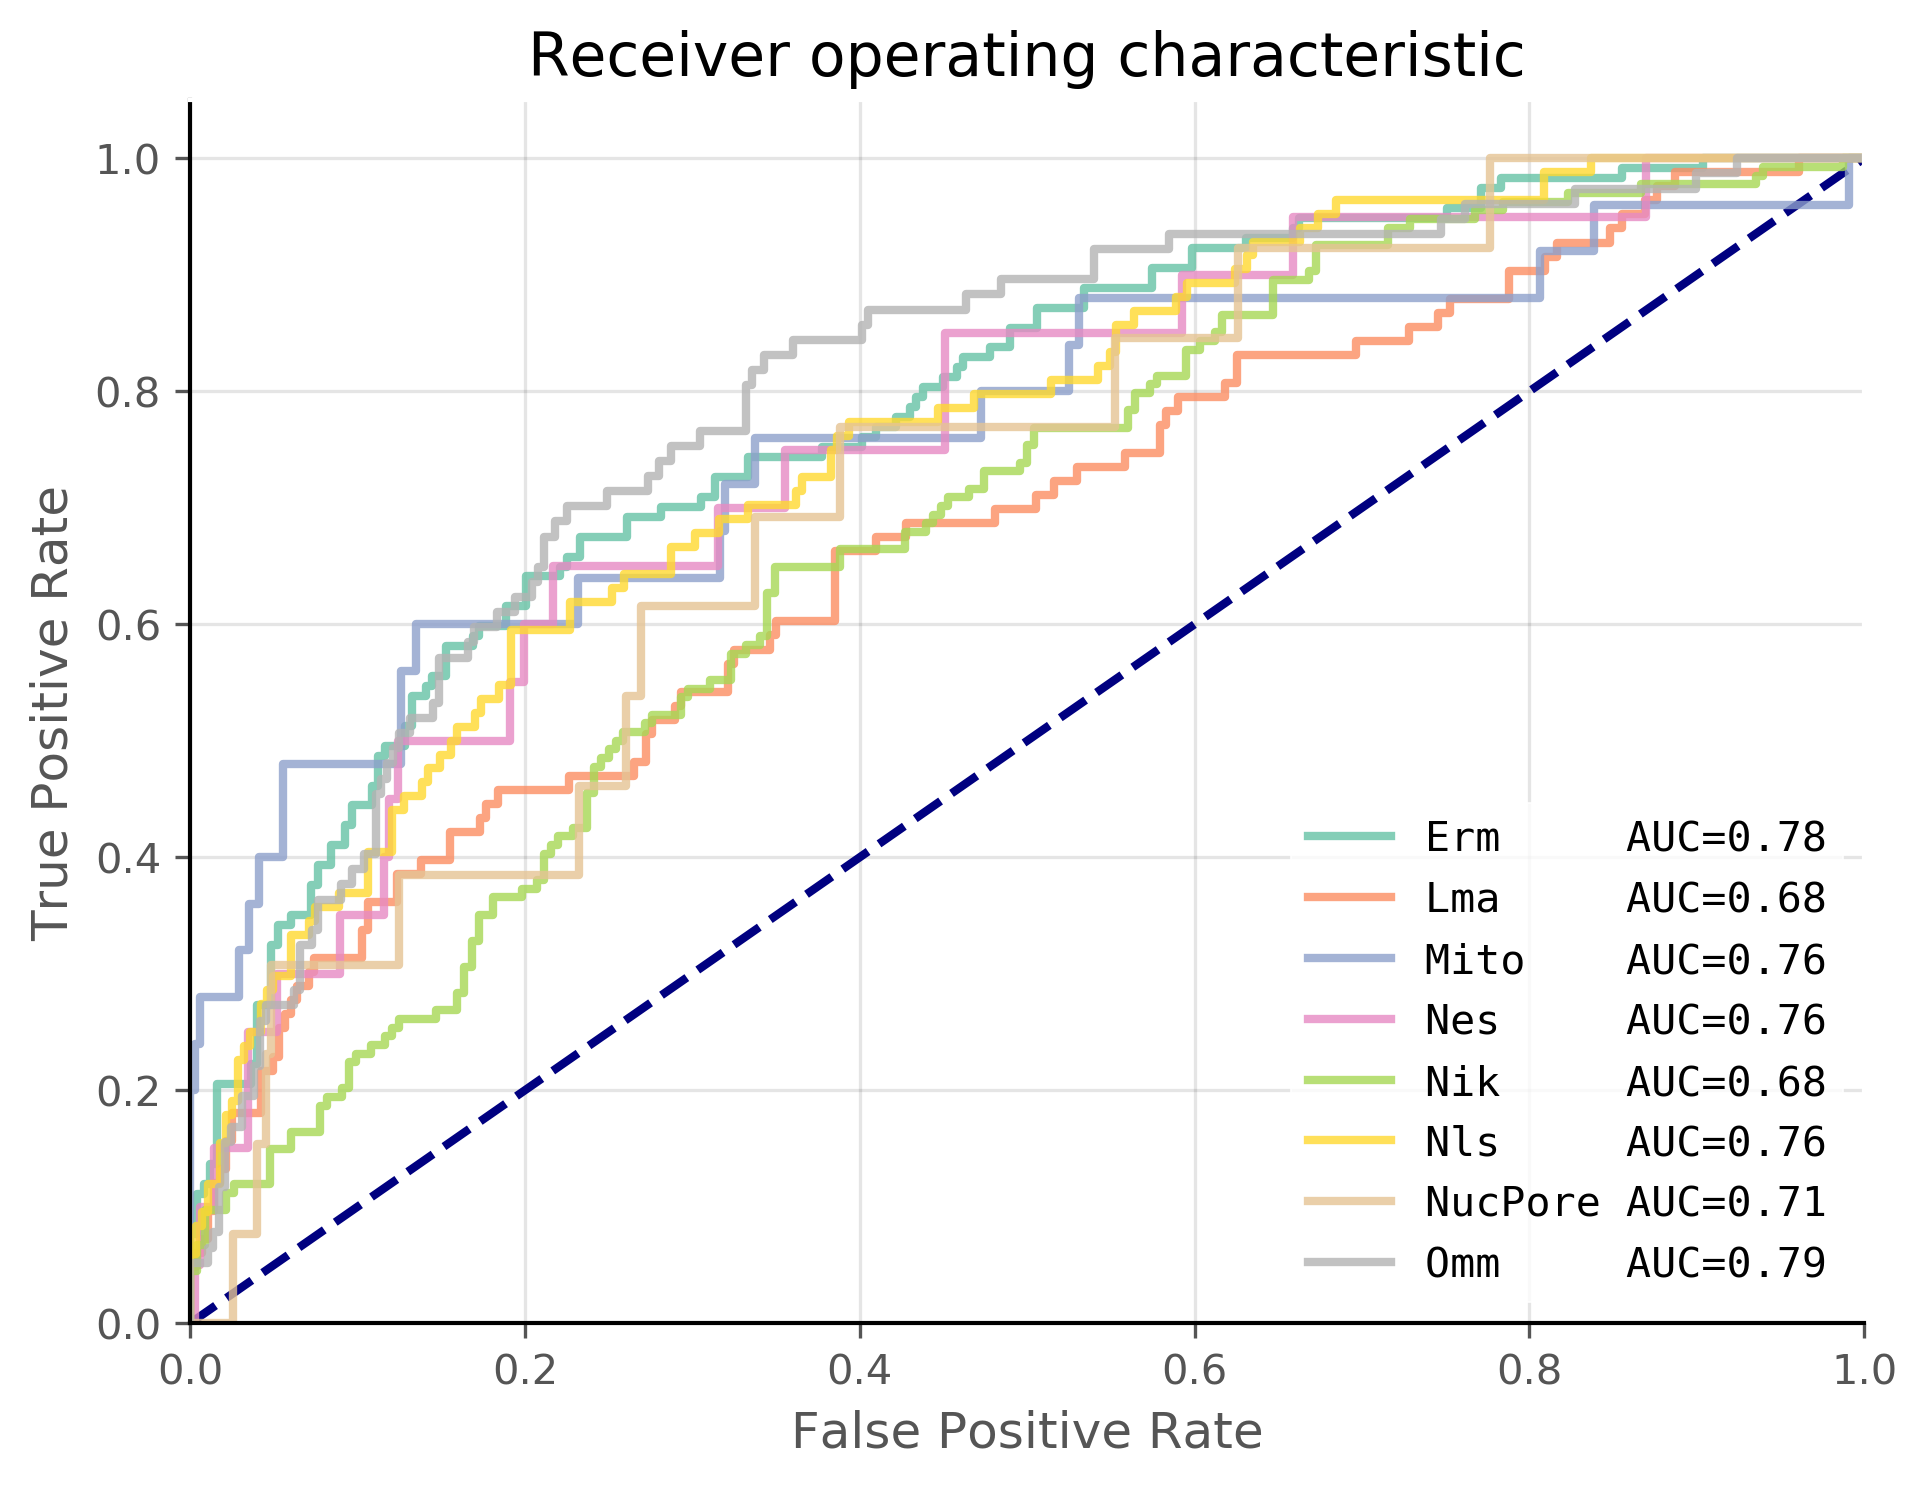

In [26]:
print("Validation AUROC: {}".format(ovr_xgb_overall_perf.auroc))
print("Validation AUROC var: {}".format(np.var([p.auroc for p in ovr_xgb_per_class_perf])))
print("Validation AUPRC: {}".format(ovr_xgb_overall_perf.auprc))
print("Validation AUPRC var: {}".format(np.var([p.auprc for p in ovr_xgb_per_class_perf])))

plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, ovr_xgb_per_class_perf)}
)

0.7641893006175149
0.4844607383576056


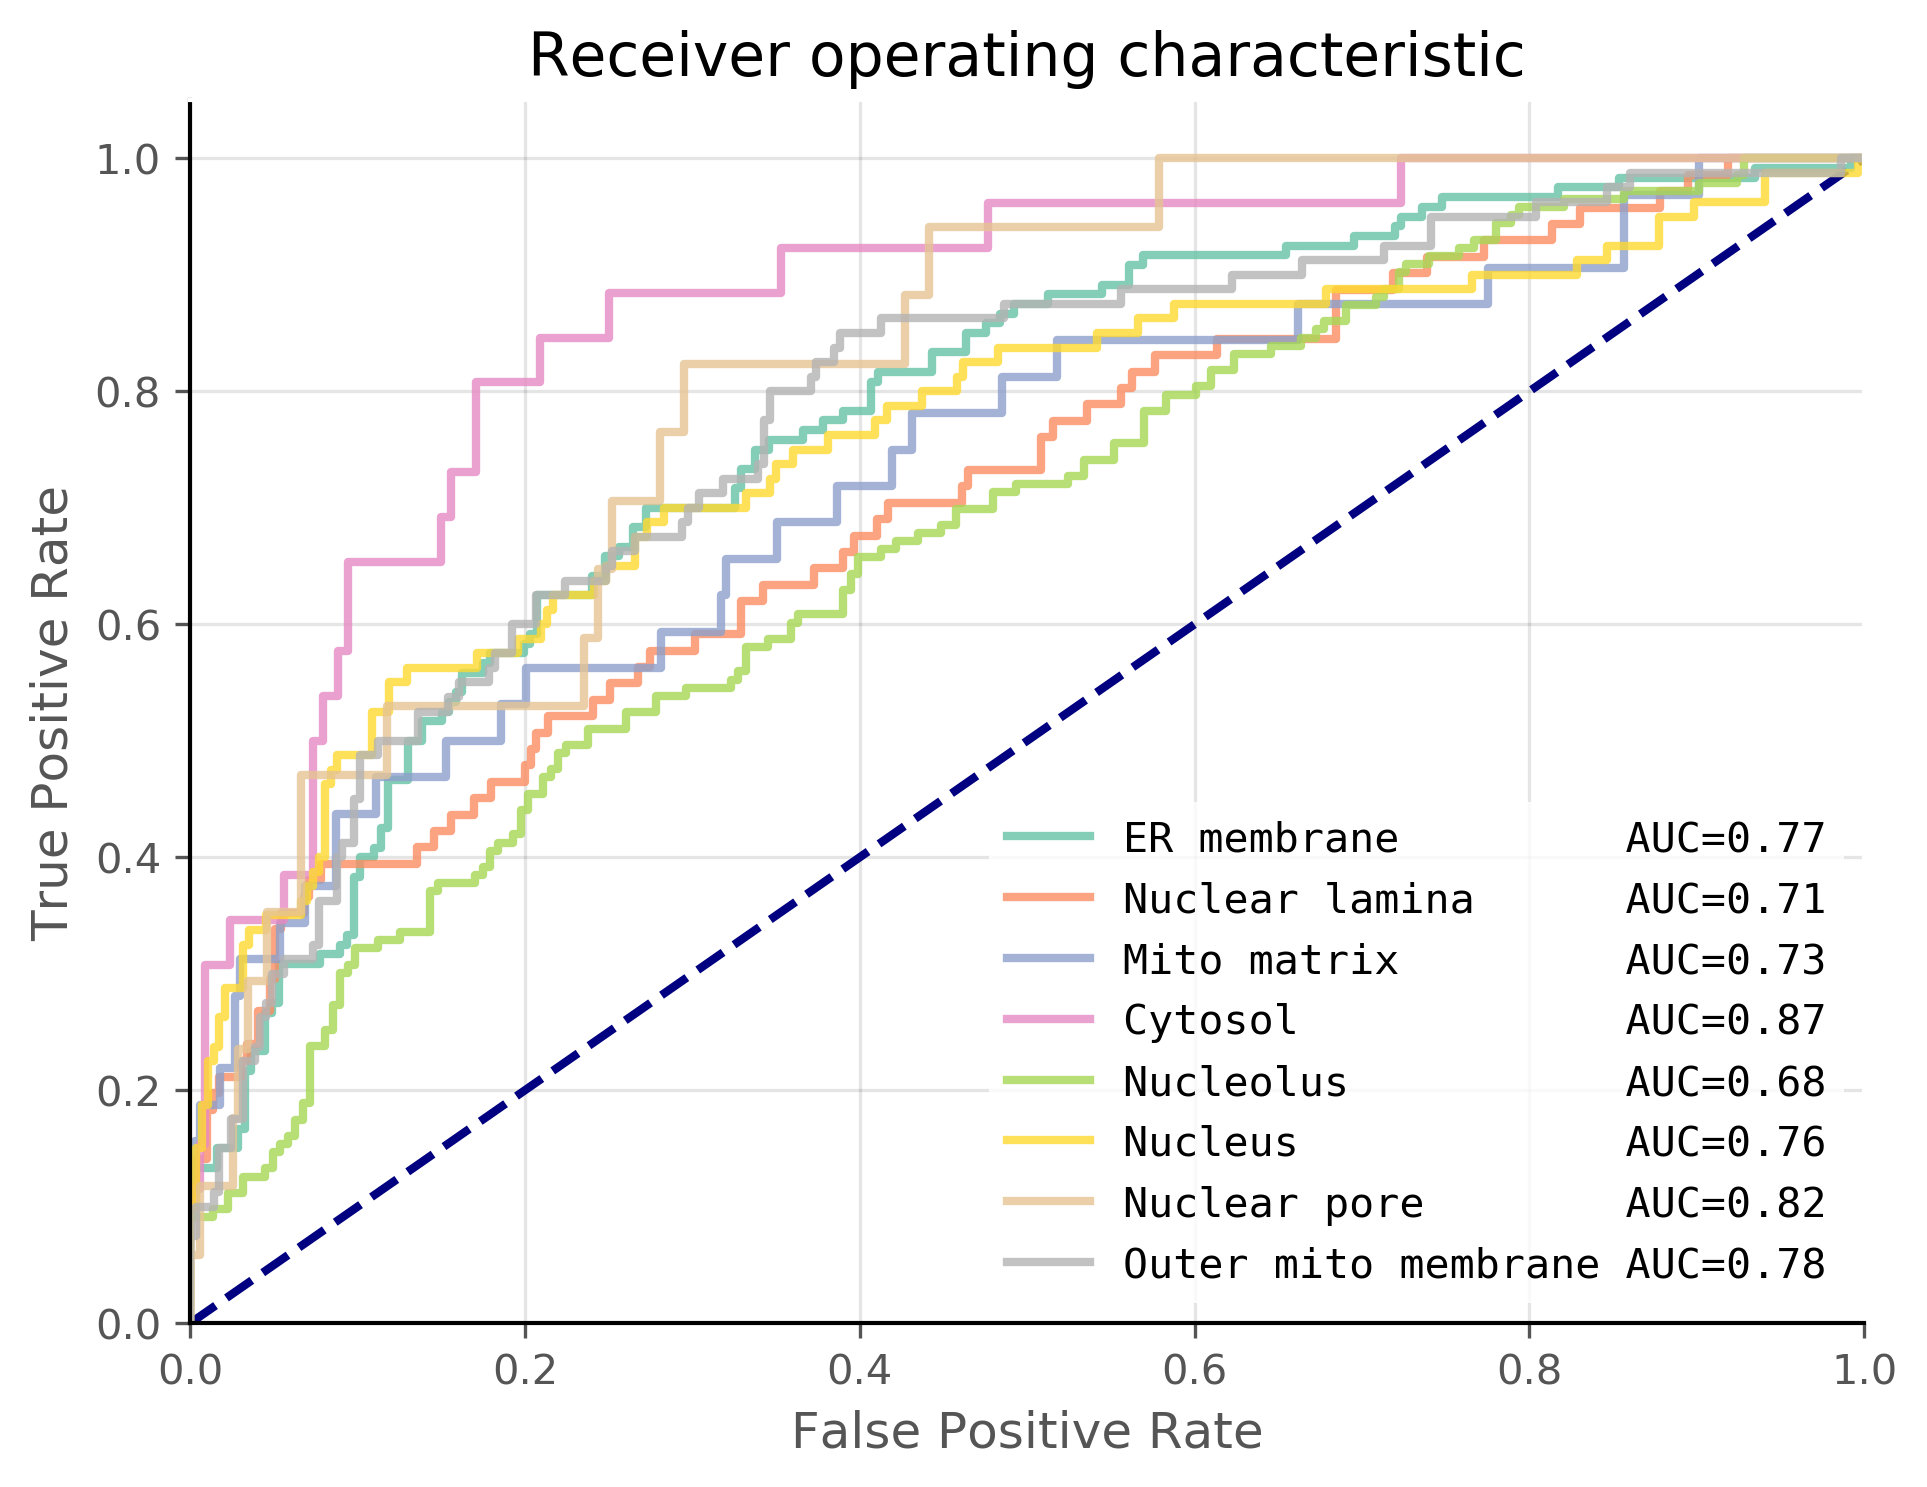

In [27]:
# Same as above, but for test set
importlib.reload(plotting_utils)
ovr_xgb_test_prob_matrix = ovr_xgb_model.predict_proba(test_data[0])
ovr_xgb_test_overall_perf = model_utils.generate_model_perf(test_data[1], ovr_xgb_test_prob_matrix, True)
ovr_xgb_test_per_class_perf = model_utils.generate_multiclass_perf(test_data[1], ovr_xgb_test_prob_matrix, 8)
print(ovr_xgb_test_overall_perf.auroc)
print(ovr_xgb_test_overall_perf.auprc)
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(test_dataset.compartments, ovr_xgb_test_per_class_perf)}
)

## Intepretation

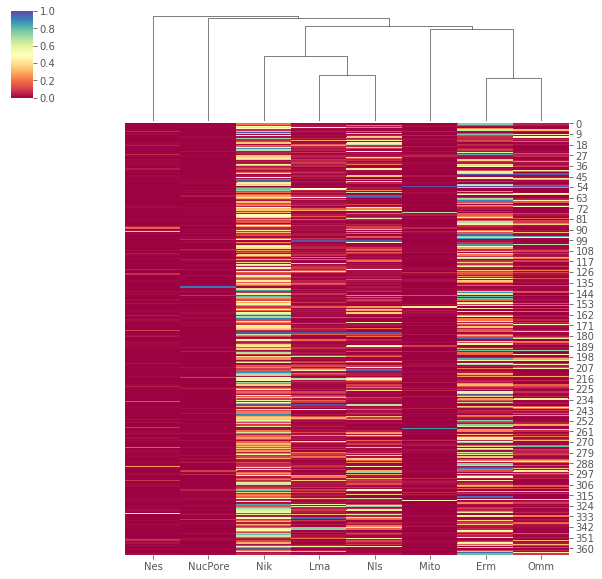

In [28]:
# Compare to just predicting istead of doing the loop over each estimator in OVR
g_test_xgb = sns.clustermap(
    pd.DataFrame(ovr_xgb_model.predict_proba(test_data[0]), columns=test_dataset.compartments),
    row_cluster=False,
    col_cluster=True,
    cmap='Spectral',
    metric='cosine',
)

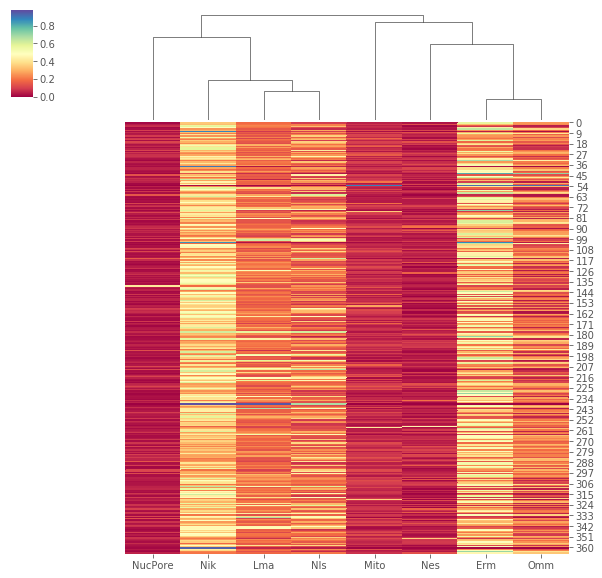

In [29]:
# Multilabel RF
rf_test_prob_matrix = np.hstack([np.atleast_2d(class_preds[:, 1]).T for class_preds in rf_optimal_model.predict_proba(test_data[0])])
g_test_rf = sns.clustermap(
    pd.DataFrame(rf_test_prob_matrix, columns=test_dataset.compartments),
    row_cluster=False,
    col_cluster=True,
    cmap='Spectral',
    metric='cosine',
)

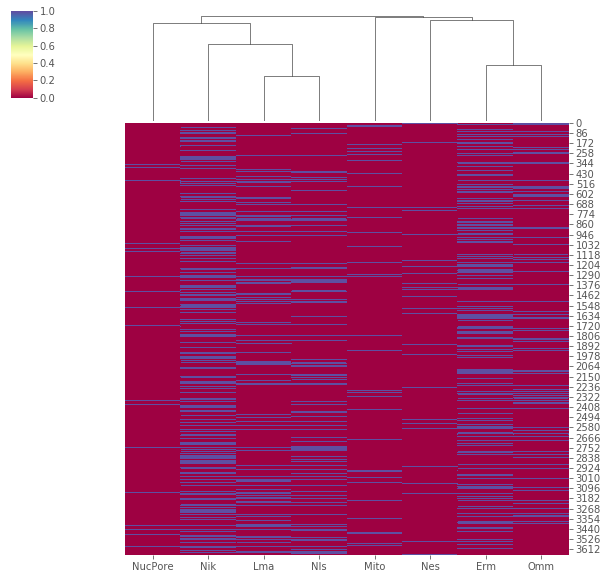

In [30]:
# Compare the above to clustering done on the actual truth labels (validation)
g_full_truths = sns.clustermap(
    pd.DataFrame(full_data[1], columns=test_dataset.compartments),
    row_cluster=False,
    col_cluster=True,
    cmap='Spectral',
    metric='cosine',
)

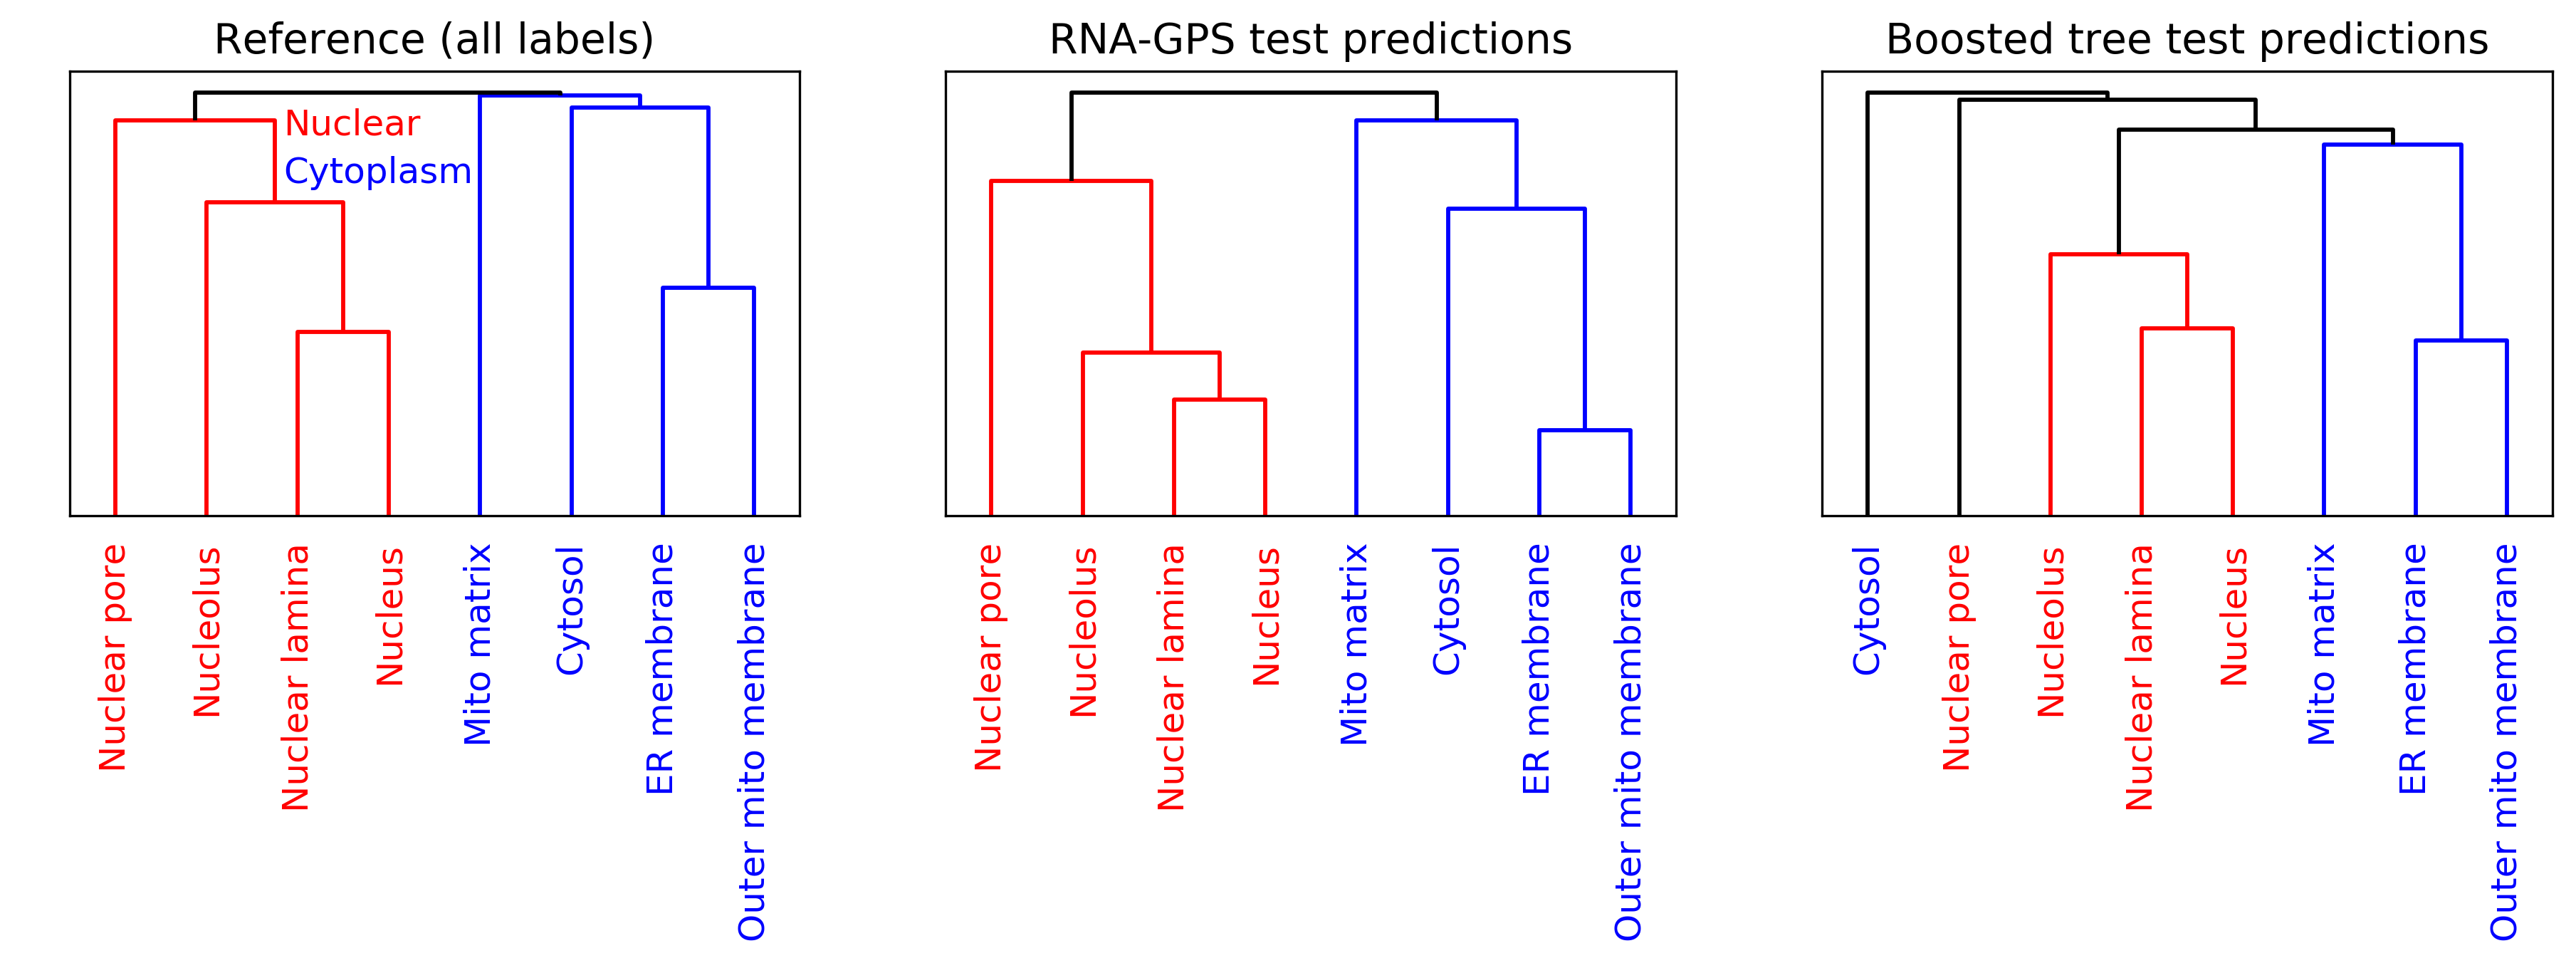

In [60]:
from scipy.cluster import hierarchy
import matplotlib.colors as mcolors

# 0.357 separates the boosted tree odd cluster out
# https://python-graph-gallery.com/401-customised-dendrogram/
# nuc_color = 'tab:red'
# cyto_color = 'tab:blue'
nuc_color = 'red'
cyto_color = 'blue'
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15, 2.7))
for g, label, thresh, ax in zip([g_full_truths, g_test_rf, g_test_xgb], ['Reference (all labels)', 'RNA-GPS test predictions', 'Boosted tree test predictions'], [0.94, 0.32, 0.85], axes):
    is_boosted = label == "Boosted tree predictions"
    hierarchy.set_link_color_palette([nuc_color, cyto_color])
    hierarchy.dendrogram(
        g.dendrogram_col.linkage,
        ax=ax,
        labels=[data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in valid_dataset.compartments],
        leaf_rotation=90,
        count_sort="ascending",
        distance_sort="ascending",
        color_threshold=thresh,
        above_threshold_color='black',
    )
    ax.set(
        title=label,
        yticks=[],  # Clear y axis labels
    )
#     ax.axvline(40, linestyle='--', color='tab:orange')
    for i in range(len(ax.get_xticklabels())):
        x = g.dendrogram_col.dendrogram['ivl'][i]  # Indices for xaxis labels
        is_nuclear = test_dataset.compartments[int(x)].lower() in ['nik', 'lma', 'nls', 'nucpore']
        plt.setp(ax.get_xticklabels()[i], color=nuc_color if is_nuclear else cyto_color)
    
# Add color coded labels
annot_x_pos = 0.11
ax.annotate("Nuclear", xy=(annot_x_pos, 0.86), xycoords='figure fraction', color=nuc_color, size='large')
ax.annotate("Cytoplasm", xy=(annot_x_pos, 0.81), xycoords='figure fraction', color=cyto_color, size='large')
# fig.suptitle("Clustering of localization compartments based on co-localizations", size='xx-large')
fig.savefig(os.path.join(PLOT_DIR, "compartment_clustering.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

## Performance by transcript length

In [32]:
seq_lens_thresholds = np.percentile(seq_lens, q=[33, 67])  # Thresholds based on full dataset
seq_lens_thresholds

array([2367.94, 4371.59])

In [33]:
test_seq_lens = [len(test_dataset.get_ith_trans_seq(i)) for i in range(len(test_dataset))]

In [34]:
test_short_indices = np.where(test_seq_lens <= seq_lens_thresholds[0])
test_short_data = (test_data[0][test_short_indices], test_data[1][test_short_indices])
test_short_data[0].shape

(113, 4032)

In [35]:
test_mid_indices = np.where(np.logical_and(
    test_seq_lens > seq_lens_thresholds[0],
    test_seq_lens <= seq_lens_thresholds[1],
))
test_mid_data = (test_data[0][test_mid_indices], test_data[1][test_mid_indices])
test_mid_data[0].shape

(140, 4032)

In [36]:
test_long_indices = np.where(test_seq_lens > seq_lens_thresholds[1])
test_long_data = (test_data[0][test_long_indices], test_data[1][test_long_indices])
test_long_data[0].shape

(113, 4032)

In [37]:
assert len(test_long_indices[0]) + len(test_mid_indices[0]) + len(test_short_indices[0]) == test_data[0].shape[0]

In [38]:
test_short_preds = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_short_data[0]))
(
    metrics.roc_auc_score(test_short_data[1], test_short_preds),
    metrics.average_precision_score(test_short_data[1], test_short_preds),
)

(0.7809384502468879, 0.5097061936288454)

In [39]:
test_mid_preds = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_mid_data[0]))
(
    metrics.roc_auc_score(test_mid_data[1], test_mid_preds),
    metrics.average_precision_score(test_mid_data[1], test_mid_preds),
)

(0.7820642513693854, 0.528581591515521)

In [41]:
test_long_preds = model_utils.list_preds_to_array_preds(rf_optimal_model.predict_proba(test_long_data[0]))
(
    metrics.roc_auc_score(test_long_data[1], test_long_preds),
    metrics.average_precision_score(test_long_data[1], test_long_preds),
)

(0.6705137540023327, 0.40712666427828514)